In a new python environment with python>=3.10

In [ ]:
!pip install "torch_uncertainty[image] @ git+https://github.com/ENSTA-U2IS-AI/torch-uncertainty@dev" > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/ENSTA-U2IS-AI/torch-uncertainty /tmp/pip-install-e9gje8ek/torch-uncertainty_dffa48b53a9247a6a0c9ddeb7465c73f
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange
from tqdm import tqdm

import torch
import torch as nn
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from torch_uncertainty.datasets import MUAD
from torchmetrics.utilities.compute import _safe_divide

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def colored_print(color, text):
    """
    Print text with the specified color and reset to default color at the end.
    Args:
        color (str): The color code from the bcolors class.
        text (str): The text to print.
    """
    print(f"{color}{text}{bcolors.ENDC}")


In [ ]:
# here are the training parameters
batch_size = 5
learning_rate =1e-3
weight_decay=2e-4
lr_decay_epochs=20
lr_decay=0.1
nb_epochs=50

In [ ]:
from torch_uncertainty.datasets import MUAD

train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)


train_set = MUAD(root='./data', target_type="semantic", version="small", split="train" , transforms=train_transform, download=True)
val_set = MUAD(root='./data', target_type="semantic", version="small", split="val" , transforms=val_transform, download=True)
test_set = MUAD(root='./data', target_type="semantic", version="small", split="test" , transforms=val_transform, download=True)

train.zip:   0%|          | 0.00/3.83G [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/511M [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/1.06G [00:00<?, ?B/s]

Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [ ]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image)

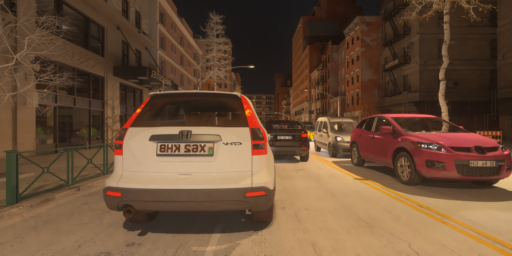

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal)

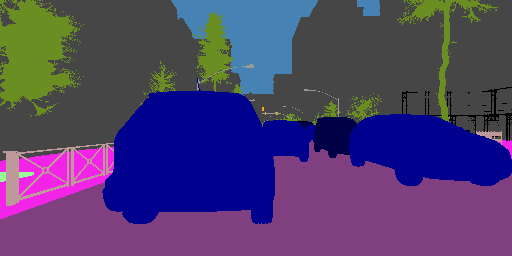

In [ ]:
tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
F.to_pil_image(img_segmented)

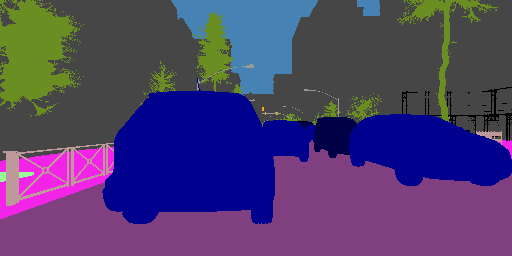

In [ ]:
tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [ ]:
class_names = [muad_class.name for muad_class in train_set.classes]
class_names = class_names[:-3]
print(class_names)
len(class_names)

['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', 'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']


19

In [ ]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name}, Train ID: {train_id}, Color: {color}")

Class: road, Train ID: 0, Color: (128, 64, 128)
Class: sidewalk, Train ID: 1, Color: (244, 35, 232)
Class: building, Train ID: 2, Color: (70, 70, 70)
Class: wall, Train ID: 3, Color: (102, 102, 156)
Class: fence, Train ID: 4, Color: (190, 153, 153)
Class: pole, Train ID: 5, Color: (153, 153, 153)
Class: traffic_light, Train ID: 6, Color: (250, 170, 30)
Class: traffic_sign, Train ID: 7, Color: (220, 220, 0)
Class: vegetation, Train ID: 8, Color: (107, 142, 35)
Class: terrain, Train ID: 9, Color: (152, 251, 152)
Class: sky, Train ID: 10, Color: (70, 130, 180)
Class: person, Train ID: 11, Color: (220, 20, 60)
Class: rider, Train ID: 12, Color: (255, 0, 0)
Class: car, Train ID: 13, Color: (0, 0, 142)
Class: truck, Train ID: 14, Color: (0, 0, 70)
Class: bus, Train ID: 15, Color: (0, 60, 100)
Class: train, Train ID: 16, Color: (0, 80, 100)
Class: motorcycle, Train ID: 17, Color: (0, 0, 230)
Class: bicycle, Train ID: 18, Color: (119, 11, 32)
Class: bear deer cow, Train ID: 19, Color: (255, 22

Here is a more comprhensive review of the diffrent classes : (while training Non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed our DNN the first raw image of the road view and as target it will be the dark image below and not the colored one (second image)

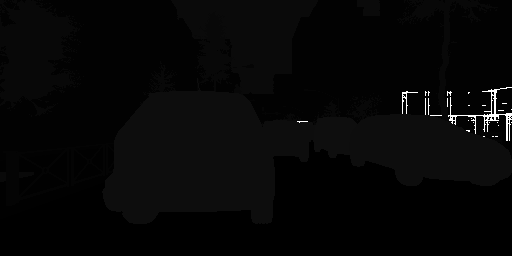

In [ ]:
im = F.to_pil_image(F.to_dtype(tgt, torch.uint8))
im

In [ ]:
im.size

(512, 256)

**Q2/ Why is the target image dark and what's the bright part ?** **(hint : print the numpy array)**

In [ ]:
img_np = np.array(tgt)

img_row = img_np[0][128]

# First row, it semes that the
print(f"First row pixels : {img_row}")
print(f"Distinct pixels value : {np.unique(img_row, return_counts=True)}")
print(f"Max value pixel {np.max(img_np)}")
print(f"Min value pixel {np.min(img_np)}")

First row pixels : [  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2  13  13  13  13  13
  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
  13  13  13  13  13  13  13  13

As we can see in the outpcell above, in the target image all same segments are grouped under the same pixel value. So in the middle row, we have 4 distinct pixels but also the brighter part (6 pixels). Each pixels it then mapped to a class ID that are descrived above.

*ps the brighter part pixel value is 255 and the class is unlabled*

**Q3/ please study the dataset a bit. What it is about?**



In [ ]:
train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2)

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2)

test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2)


In [ ]:
### Exploration of dataset

colored_print(bcolors.OKGREEN, f"Training set size: {len(train_set)}")
colored_print(bcolors.OKGREEN, f"Validation set size: {len(val_set)}")
colored_print(bcolors.OKGREEN, f"Test set size: {len(test_set)}")


Training set size: 400
Validation set size: 54
Test set size: 112


Text(0.5, 1.0, 'Test Dataset')

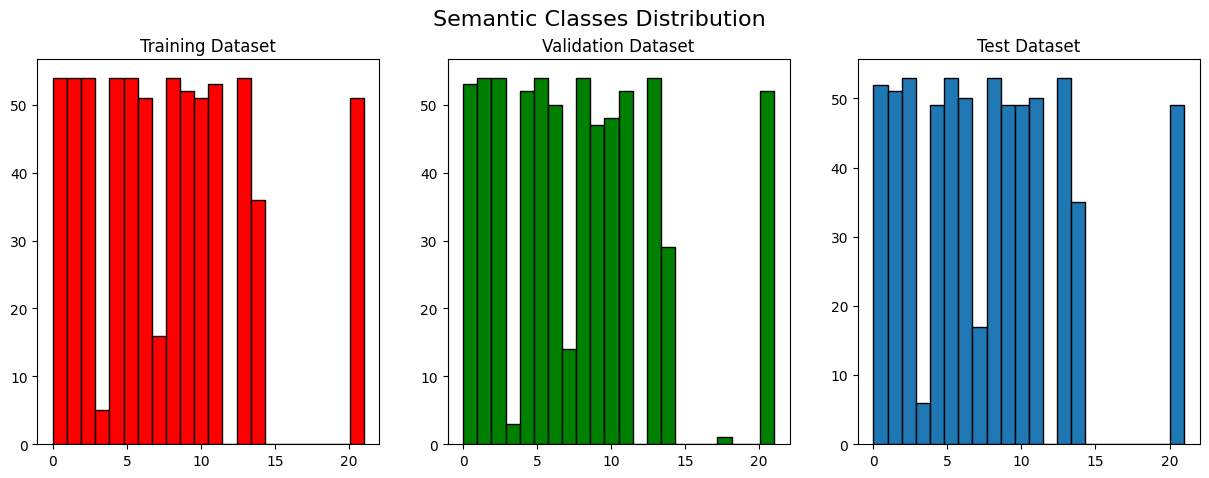

In [ ]:
train_classes = np.array([])
test_classes = np.array([])
val_classes = np.array([])

for train_sample, val_sample, test_sample in zip(train_set, val_set, test_set):
    train_img, train_tgt = train_sample
    val_img, val_tgt = val_sample
    test_img, test_tgt = test_sample

    train_tgt = train_tgt.masked_fill(train_tgt == 255, 21)
    test_tgt = test_tgt.masked_fill(test_tgt == 255, 21)
    val_tgt = val_tgt.masked_fill(val_tgt == 255, 21)

    train_classes = np.concatenate((train_classes, train_tgt.unique().numpy()))
    test_classes = np.concatenate((test_classes, test_tgt.unique().numpy()))
    val_classes = np.concatenate((val_classes, val_tgt.unique().numpy()))


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Semantic Classes Distribution', fontsize=16)

ax1.hist(train_classes, bins=22, edgecolor='black', color='red')
ax1.set_title('Training Dataset')

ax2.hist(val_classes , bins=22, edgecolor='black', color='green')
ax2.set_title('Validation Dataset')

ax3.hist(test_classes, bins=22,  edgecolor='black')
ax3.set_title('Test Dataset')

We can see that there's the class ID 18 only in the validation test. It means that it'll will distrub a bit our accuracy and metrics since model wouldb't be trained for this class (bicycle)

---

In [ ]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): AN additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0
    for _, label in dataloader:
      label = label.cpu().numpy()
      # Flatten label
      flat_label = label.flatten()
      flat_label = flat_label[flat_label != 255]

      # Sum up the number of pixels of each class and the total pixel
      # counts for each label
      class_count += np.bincount(flat_label, minlength=num_classes)
      total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [ ]:
print("\nComputing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 19)
class_weights = torch.from_numpy(class_weights).float().cuda()
print("Class weights:", class_weights)


Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444, 50.4983,  5.2256, 21.1894, 50.4983,
        50.4983, 50.4983, 50.4983], device='cuda:0')


**Q4/ why do we need to evaluate the class_weights?**

For image segmentation tasks Class weights are used to address the imbalance in pixel distributions, where certain classes (e.g., background) dominate over others. They ensure the model learns to focus on less-represented classes, improving accuracy and generalization across all categories.

## C. building the DNN

**Q5/ Do we really use Unet? What did I change :)? (that is hard)**


| **Aspect**                  | **Original U-Net**             | **This Implementation**           |
|-----------------------------|---------------------------------|------------------------------------|
| Starting Feature Maps       | 64                             | 32                                 |
| Maximum Feature Maps        | 512                            | 256                                |
| Dropout                     | No                             | Yes (MC Dropout with 0.1)          |
| Upsampling                  | `ConvTranspose2d`              | Bilinear (optional) + `ConvTranspose2d` |
| Batch Normalization         | No                             | Yes                                |
| Padding                     | Not explicitly handled         | Handled with `F.pad`              |
| Target Use Case             | Biomedical image segmentation  | General segmentation with MC Dropout |


---
**Q6/Do we need a backbone with Unet?**


we likely don’t need a backbone because U-Net can learn features effectively from scratch, especially if we have sufficient labeled data. Additionally, using a backbone might not align well if our dataset significantly differs from those the backbone is pre-trained on (e.g., ImageNet).

In [ ]:
class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear

        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.resize(x1, size=[2*x1.size()[2],2*x1.size()[3]],
                          interpolation=v2.InterpolationMode.BILINEAR)
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

#please note that we have added dropout layer to be abble to use MC dropout

class UNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

## D. Utility functions

In [ ]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.show()

**Q7/  what is the IoU?**


The **Intersection over Union (IoU)** is a metric used to evaluate the performance of image segmentation models. It measures the overlap between the predicted segmentation and the ground truth:

$IoU = \frac{\text{Area of Overlap}}{\text{Area of Union}}$

A higher IoU indicates better alignment between predictions and the ground truth, with values ranging from 0 (no overlap) to 1 (perfect overlap).


### Training function

**Q8/Please complete the training and the test function**

In [ ]:
def train( model, data_loader, optim, criterion, metric,iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()

        # Forward propagation
        logits = model(img)
        flatten_logits = rearrange(logits, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()

        valid_mask = flatten_labels != 255

        # Loss computation
        loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])

        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        metric.update(flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach())
        # colored_print(bcolors.WARNING, f"\n\n[INFO] flatten_logits[valid_mask], flatten_labels[valid_mask] : \n\n {flatten_logits[valid_mask], flatten_labels[valid_mask]}")


        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))
    for class_name, iou in zip(class_names, iou_per_class):
        colored_print(bcolors.WARNING, f"{class_name}: {iou:.4f}")

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

### Validation function

In [ ]:
def test(model, data_loader, criterion, metric, iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()

        with torch.no_grad():
            # Forward propagation
            logits = model(img)
            flattent_logits = rearrange(logits, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()

            valid_mask = flatten_labels != 255

            # Loss computation
            loss = criterion(flattent_logits[valid_mask], flatten_labels[valid_mask])

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flattent_logits[valid_mask], flatten_labels[valid_mask])

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    # for class_name, iou in zip(class_names, iou_per_class):
    #     colored_print(bcolors.WARNING, f"VALIDATION : {class_name}: {iou:.4f}")


    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

## E. Training Process

**Q9/ please train your DNN and comment?**



### PLOT THE LOSS Training & Validation !

In [ ]:
# Fix all seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def plot_losses(train_history, val_history,i):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.savefig(f"/content/drive/MyDrive/Computer-Vision/loss_{i}.png")
    plt.show()

def plot_accu(train_history, val_history,i):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.savefig(f"/content/drive/MyDrive/Computer-Vision/miou_{i}.png")
    plt.show()


Training...


Starting Training...



Training Epochs :   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50

[Step: 0] Iteration loss: 3.0503
[Step: 1] Iteration loss: 2.9005
[Step: 2] Iteration loss: 2.9507
[Step: 3] Iteration loss: 2.9227
[Step: 4] Iteration loss: 2.7388
[Step: 5] Iteration loss: 2.6631
[Step: 6] Iteration loss: 2.6227
[Step: 7] Iteration loss: 2.5920
[Step: 8] Iteration loss: 2.6084
[Step: 9] Iteration loss: 2.5803
[Step: 10] Iteration loss: 2.4407
[Step: 11] Iteration loss: 2.5141
[Step: 12] Iteration loss: 2.5585
[Step: 13] Iteration loss: 2.3789
[Step: 14] Iteration loss: 2.5425
[Step: 15] Iteration loss: 2.2764
[Step: 16] Iteration loss: 2.2631
[Step: 17] Iteration loss: 2.3368
[Step: 18] Iteration loss: 2.2165
[Step: 19] Iteration loss: 2.2819
[Step: 20] Iteration loss: 2.1497
[Step: 21] Iteration loss: 2.2609
[Step: 22] Iteration loss: 2.3423
[Step: 23] Iteration loss: 2.0961
[Step: 24] Iteration loss: 2.1345
[Step: 25] Iteration loss: 2.2521
[Step: 26] Iteration loss: 2.2553
[Step: 27] Iteration loss: 2.0889
[Step: 28] Iteration loss: 2.1622
[Step: 29] I

Training Epochs :   2%|▏         | 1/50 [01:47<1:27:25, 107.04s/it]

[Step: 10] Iteration loss: 1.7636
Train Loss: 1.9714, Train IoU: 0.1045
Validation Loss: 1.5736, Validation IoU: 0.1317
Model saved with Validation Loss: 1.5736
Epoch 2/50

[Step: 0] Iteration loss: 1.3109
[Step: 1] Iteration loss: 1.6083
[Step: 2] Iteration loss: 1.3076
[Step: 3] Iteration loss: 1.4184
[Step: 4] Iteration loss: 1.5875
[Step: 5] Iteration loss: 1.1752
[Step: 6] Iteration loss: 1.2382
[Step: 7] Iteration loss: 1.2760
[Step: 8] Iteration loss: 1.4362
[Step: 9] Iteration loss: 1.3125
[Step: 10] Iteration loss: 1.5442
[Step: 11] Iteration loss: 1.2843
[Step: 12] Iteration loss: 1.3190
[Step: 13] Iteration loss: 1.4099
[Step: 14] Iteration loss: 1.4353
[Step: 15] Iteration loss: 1.3493
[Step: 16] Iteration loss: 1.1854
[Step: 17] Iteration loss: 1.2550
[Step: 18] Iteration loss: 1.1971
[Step: 19] Iteration loss: 1.3541
[Step: 20] Iteration loss: 1.1844
[Step: 21] Iteration loss: 1.2714
[Step: 22] Iteration loss: 1.1899
[Step: 23] Iteration loss: 1.2270
[Step: 24] Iteration 

Training Epochs :   4%|▍         | 2/50 [03:30<1:24:08, 105.17s/it]

[Step: 10] Iteration loss: 1.2844
Train Loss: 1.1146, Train IoU: 0.1949
Validation Loss: 1.0013, Validation IoU: 0.1825
Model saved with Validation Loss: 1.0013
Epoch 3/50

[Step: 0] Iteration loss: 0.8963
[Step: 1] Iteration loss: 0.7859
[Step: 2] Iteration loss: 1.0162
[Step: 3] Iteration loss: 0.9366
[Step: 4] Iteration loss: 0.8776
[Step: 5] Iteration loss: 0.7986
[Step: 6] Iteration loss: 0.8005
[Step: 7] Iteration loss: 0.7575
[Step: 8] Iteration loss: 0.9317
[Step: 9] Iteration loss: 0.9859
[Step: 10] Iteration loss: 0.9064
[Step: 11] Iteration loss: 0.7460
[Step: 12] Iteration loss: 1.1096
[Step: 13] Iteration loss: 1.1280
[Step: 14] Iteration loss: 1.0478
[Step: 15] Iteration loss: 0.9554
[Step: 16] Iteration loss: 0.9586
[Step: 17] Iteration loss: 0.9586
[Step: 18] Iteration loss: 0.8924
[Step: 19] Iteration loss: 0.9250
[Step: 20] Iteration loss: 0.9217
[Step: 21] Iteration loss: 0.8855
[Step: 22] Iteration loss: 0.8717
[Step: 23] Iteration loss: 0.8118
[Step: 24] Iteration 

Training Epochs :   6%|▌         | 3/50 [05:20<1:24:06, 107.38s/it]

Model saved with Validation Loss: 0.9406
Epoch 4/50

[Step: 0] Iteration loss: 0.8687
[Step: 1] Iteration loss: 0.6930
[Step: 2] Iteration loss: 0.8728
[Step: 3] Iteration loss: 0.8699
[Step: 4] Iteration loss: 0.7548
[Step: 5] Iteration loss: 0.7302
[Step: 6] Iteration loss: 0.8646
[Step: 7] Iteration loss: 1.0349
[Step: 8] Iteration loss: 0.7668
[Step: 9] Iteration loss: 0.9201
[Step: 10] Iteration loss: 1.3090
[Step: 11] Iteration loss: 0.7361
[Step: 12] Iteration loss: 0.7882
[Step: 13] Iteration loss: 0.7107
[Step: 14] Iteration loss: 0.7007
[Step: 15] Iteration loss: 1.2812
[Step: 16] Iteration loss: 0.7641
[Step: 17] Iteration loss: 0.8735
[Step: 18] Iteration loss: 0.8040
[Step: 19] Iteration loss: 0.7910
[Step: 20] Iteration loss: 0.7496
[Step: 21] Iteration loss: 0.6724
[Step: 22] Iteration loss: 0.6980
[Step: 23] Iteration loss: 0.7675
[Step: 24] Iteration loss: 0.9724
[Step: 25] Iteration loss: 1.0309
[Step: 26] Iteration loss: 0.8022
[Step: 27] Iteration loss: 0.7293
[Step

Training Epochs :   8%|▊         | 4/50 [06:57<1:18:56, 102.96s/it]

[Step: 10] Iteration loss: 1.0806
Train Loss: 0.7899, Train IoU: 0.2318
Validation Loss: 0.7988, Validation IoU: 0.2181
Model saved with Validation Loss: 0.7988
Epoch 5/50

[Step: 0] Iteration loss: 0.7434
[Step: 1] Iteration loss: 0.9839
[Step: 2] Iteration loss: 0.8130
[Step: 3] Iteration loss: 0.7237
[Step: 4] Iteration loss: 0.7038
[Step: 5] Iteration loss: 0.6278
[Step: 6] Iteration loss: 1.0174
[Step: 7] Iteration loss: 0.6871
[Step: 8] Iteration loss: 0.7120
[Step: 9] Iteration loss: 0.6853
[Step: 10] Iteration loss: 0.7041
[Step: 11] Iteration loss: 0.5891
[Step: 12] Iteration loss: 0.5732
[Step: 13] Iteration loss: 0.7999
[Step: 14] Iteration loss: 0.6885
[Step: 15] Iteration loss: 0.8009
[Step: 16] Iteration loss: 0.5773
[Step: 17] Iteration loss: 1.0452
[Step: 18] Iteration loss: 0.6439
[Step: 19] Iteration loss: 0.7600
[Step: 20] Iteration loss: 0.6436
[Step: 21] Iteration loss: 0.6091
[Step: 22] Iteration loss: 0.8858
[Step: 23] Iteration loss: 0.7542
[Step: 24] Iteration 

Training Epochs :  10%|█         | 5/50 [08:32<1:15:16, 100.36s/it]

[Step: 10] Iteration loss: 0.9297
Train Loss: 0.7140, Train IoU: 0.2544
Validation Loss: 0.6892, Validation IoU: 0.2466
Model saved with Validation Loss: 0.6892
Epoch 6/50

[Step: 0] Iteration loss: 0.9832
[Step: 1] Iteration loss: 0.5148
[Step: 2] Iteration loss: 0.5455
[Step: 3] Iteration loss: 0.5717
[Step: 4] Iteration loss: 0.6306
[Step: 5] Iteration loss: 0.5342
[Step: 6] Iteration loss: 0.7017
[Step: 7] Iteration loss: 0.7519
[Step: 8] Iteration loss: 0.5123
[Step: 9] Iteration loss: 0.4447
[Step: 10] Iteration loss: 0.9458
[Step: 11] Iteration loss: 0.7431
[Step: 12] Iteration loss: 0.8256
[Step: 13] Iteration loss: 0.5072
[Step: 14] Iteration loss: 0.5249
[Step: 15] Iteration loss: 0.5174
[Step: 16] Iteration loss: 0.5847
[Step: 17] Iteration loss: 0.7555
[Step: 18] Iteration loss: 0.4887
[Step: 19] Iteration loss: 0.7084
[Step: 20] Iteration loss: 0.6468
[Step: 21] Iteration loss: 0.6074
[Step: 22] Iteration loss: 0.7606
[Step: 23] Iteration loss: 0.7925
[Step: 24] Iteration 

Training Epochs :  12%|█▏        | 6/50 [10:08<1:12:30, 98.87s/it] 

Model saved with Validation Loss: 0.6189
Epoch 7/50

[Step: 0] Iteration loss: 0.6808
[Step: 1] Iteration loss: 0.6876
[Step: 2] Iteration loss: 0.5889
[Step: 3] Iteration loss: 0.4731
[Step: 4] Iteration loss: 0.4605
[Step: 5] Iteration loss: 0.8367
[Step: 6] Iteration loss: 0.5820
[Step: 7] Iteration loss: 0.7100
[Step: 8] Iteration loss: 0.5279
[Step: 9] Iteration loss: 0.7683
[Step: 10] Iteration loss: 0.5506
[Step: 11] Iteration loss: 0.5540
[Step: 12] Iteration loss: 0.5837
[Step: 13] Iteration loss: 0.6052
[Step: 14] Iteration loss: 0.6316
[Step: 15] Iteration loss: 0.5744
[Step: 16] Iteration loss: 0.5377
[Step: 17] Iteration loss: 0.5721
[Step: 18] Iteration loss: 0.5560
[Step: 19] Iteration loss: 0.6845
[Step: 20] Iteration loss: 0.6752
[Step: 21] Iteration loss: 0.6958
[Step: 22] Iteration loss: 0.5698
[Step: 23] Iteration loss: 0.6452
[Step: 24] Iteration loss: 0.5399
[Step: 25] Iteration loss: 0.4786
[Step: 26] Iteration loss: 0.7625
[Step: 27] Iteration loss: 0.7399
[Step

Training Epochs :  14%|█▍        | 7/50 [11:40<1:09:08, 96.48s/it]

[Step: 10] Iteration loss: 1.0080
Train Loss: 0.6291, Train IoU: 0.2802
Validation Loss: 0.8941, Validation IoU: 0.1946
Epoch 8/50

[Step: 0] Iteration loss: 0.4877
[Step: 1] Iteration loss: 0.5821
[Step: 2] Iteration loss: 1.0135
[Step: 3] Iteration loss: 0.6561
[Step: 4] Iteration loss: 0.5244
[Step: 5] Iteration loss: 0.6576
[Step: 6] Iteration loss: 0.5669
[Step: 7] Iteration loss: 0.7383
[Step: 8] Iteration loss: 0.7180
[Step: 9] Iteration loss: 0.6717
[Step: 10] Iteration loss: 0.6098
[Step: 11] Iteration loss: 0.6169
[Step: 12] Iteration loss: 0.5487
[Step: 13] Iteration loss: 0.6585
[Step: 14] Iteration loss: 0.7763
[Step: 15] Iteration loss: 0.5607
[Step: 16] Iteration loss: 0.6436
[Step: 17] Iteration loss: 0.7390
[Step: 18] Iteration loss: 0.6061
[Step: 19] Iteration loss: 0.5311
[Step: 20] Iteration loss: 0.7597
[Step: 21] Iteration loss: 0.5348
[Step: 22] Iteration loss: 0.6815
[Step: 23] Iteration loss: 0.4618
[Step: 24] Iteration loss: 0.6036
[Step: 25] Iteration loss: 0

Training Epochs :  16%|█▌        | 8/50 [13:15<1:07:18, 96.14s/it]

[Step: 10] Iteration loss: 0.8776
Train Loss: 0.6071, Train IoU: 0.2919
Validation Loss: 0.6028, Validation IoU: 0.2864
Model saved with Validation Loss: 0.6028
Epoch 9/50

[Step: 0] Iteration loss: 0.6798
[Step: 1] Iteration loss: 0.5137
[Step: 2] Iteration loss: 0.5015
[Step: 3] Iteration loss: 0.7866
[Step: 4] Iteration loss: 0.5074
[Step: 5] Iteration loss: 0.5715
[Step: 6] Iteration loss: 0.4370
[Step: 7] Iteration loss: 1.0240
[Step: 8] Iteration loss: 0.5726
[Step: 9] Iteration loss: 0.6084
[Step: 10] Iteration loss: 0.6287
[Step: 11] Iteration loss: 0.6057
[Step: 12] Iteration loss: 0.6465
[Step: 13] Iteration loss: 0.6975
[Step: 14] Iteration loss: 0.5591
[Step: 15] Iteration loss: 0.5620
[Step: 16] Iteration loss: 0.7299
[Step: 17] Iteration loss: 0.6254
[Step: 18] Iteration loss: 0.7222
[Step: 19] Iteration loss: 0.4939
[Step: 20] Iteration loss: 0.4375
[Step: 21] Iteration loss: 0.5802
[Step: 22] Iteration loss: 0.4623
[Step: 23] Iteration loss: 0.5862
[Step: 24] Iteration 

Training Epochs :  18%|█▊        | 9/50 [14:52<1:05:43, 96.18s/it]

[Step: 10] Iteration loss: 0.7917
Train Loss: 0.5754, Train IoU: 0.3015
Validation Loss: 0.6245, Validation IoU: 0.2825
Epoch 10/50

[Step: 0] Iteration loss: 0.5664
[Step: 1] Iteration loss: 0.6127
[Step: 2] Iteration loss: 0.3911
[Step: 3] Iteration loss: 0.5918
[Step: 4] Iteration loss: 0.6049
[Step: 5] Iteration loss: 0.8992
[Step: 6] Iteration loss: 0.5833
[Step: 7] Iteration loss: 0.4299
[Step: 8] Iteration loss: 0.4791
[Step: 9] Iteration loss: 0.4914
[Step: 10] Iteration loss: 0.5002
[Step: 11] Iteration loss: 0.6969
[Step: 12] Iteration loss: 0.6254
[Step: 13] Iteration loss: 0.5982
[Step: 14] Iteration loss: 0.5258
[Step: 15] Iteration loss: 0.5364
[Step: 16] Iteration loss: 0.6799
[Step: 17] Iteration loss: 0.5468
[Step: 18] Iteration loss: 0.5810
[Step: 19] Iteration loss: 0.4762
[Step: 20] Iteration loss: 0.7741
[Step: 21] Iteration loss: 0.6640
[Step: 22] Iteration loss: 0.4734
[Step: 23] Iteration loss: 0.4898
[Step: 24] Iteration loss: 0.3965
[Step: 25] Iteration loss: 

Training Epochs :  20%|██        | 10/50 [16:29<1:04:23, 96.59s/it]

[Step: 10] Iteration loss: 0.9596
Train Loss: 0.5437, Train IoU: 0.3153
Validation Loss: 0.6499, Validation IoU: 0.2750
Epoch 11/50

[Step: 0] Iteration loss: 0.6576
[Step: 1] Iteration loss: 0.6554
[Step: 2] Iteration loss: 0.4800
[Step: 3] Iteration loss: 0.4949
[Step: 4] Iteration loss: 0.6309
[Step: 5] Iteration loss: 0.4372
[Step: 6] Iteration loss: 0.6567
[Step: 7] Iteration loss: 0.4793
[Step: 8] Iteration loss: 0.5016
[Step: 9] Iteration loss: 0.5163
[Step: 10] Iteration loss: 0.5020
[Step: 11] Iteration loss: 0.4658
[Step: 12] Iteration loss: 0.4997
[Step: 13] Iteration loss: 0.4400
[Step: 14] Iteration loss: 0.4802
[Step: 15] Iteration loss: 0.5657
[Step: 16] Iteration loss: 0.6303
[Step: 17] Iteration loss: 0.5063
[Step: 18] Iteration loss: 0.5799
[Step: 19] Iteration loss: 0.4046
[Step: 20] Iteration loss: 0.4909
[Step: 21] Iteration loss: 0.6004
[Step: 22] Iteration loss: 0.5637
[Step: 23] Iteration loss: 0.3297
[Step: 24] Iteration loss: 0.4294
[Step: 25] Iteration loss: 

Training Epochs :  22%|██▏       | 11/50 [18:01<1:01:56, 95.29s/it]

[Step: 10] Iteration loss: 0.7003
Train Loss: 0.4922, Train IoU: 0.3307
Validation Loss: 0.4696, Validation IoU: 0.3195
Model saved with Validation Loss: 0.4696
Epoch 12/50

[Step: 0] Iteration loss: 0.3443
[Step: 1] Iteration loss: 0.4390
[Step: 2] Iteration loss: 0.5519
[Step: 3] Iteration loss: 0.3505
[Step: 4] Iteration loss: 0.5767
[Step: 5] Iteration loss: 0.4294
[Step: 6] Iteration loss: 0.4327
[Step: 7] Iteration loss: 0.5760
[Step: 8] Iteration loss: 0.3948
[Step: 9] Iteration loss: 0.3564
[Step: 10] Iteration loss: 0.3128
[Step: 11] Iteration loss: 0.4098
[Step: 12] Iteration loss: 0.4253
[Step: 13] Iteration loss: 0.5535
[Step: 14] Iteration loss: 0.5079
[Step: 15] Iteration loss: 0.5557
[Step: 16] Iteration loss: 0.5040
[Step: 17] Iteration loss: 0.3864
[Step: 18] Iteration loss: 0.3861
[Step: 19] Iteration loss: 0.5122
[Step: 20] Iteration loss: 0.4062
[Step: 21] Iteration loss: 0.5942
[Step: 22] Iteration loss: 0.3505
[Step: 23] Iteration loss: 0.3544
[Step: 24] Iteration

Training Epochs :  24%|██▍       | 12/50 [19:37<1:00:22, 95.33s/it]

[Step: 10] Iteration loss: 0.6685
Train Loss: 0.4561, Train IoU: 0.3427
Validation Loss: 0.4500, Validation IoU: 0.3285
Model saved with Validation Loss: 0.4500
Epoch 13/50

[Step: 0] Iteration loss: 0.3213
[Step: 1] Iteration loss: 0.6209
[Step: 2] Iteration loss: 0.4284
[Step: 3] Iteration loss: 0.5406
[Step: 4] Iteration loss: 0.4581
[Step: 5] Iteration loss: 0.4944
[Step: 6] Iteration loss: 0.4706
[Step: 7] Iteration loss: 0.4490
[Step: 8] Iteration loss: 0.3431
[Step: 9] Iteration loss: 0.4136
[Step: 10] Iteration loss: 0.6325
[Step: 11] Iteration loss: 0.3607
[Step: 12] Iteration loss: 0.3342
[Step: 13] Iteration loss: 0.4289
[Step: 14] Iteration loss: 0.4067
[Step: 15] Iteration loss: 0.3452
[Step: 16] Iteration loss: 0.3650
[Step: 17] Iteration loss: 0.6095
[Step: 18] Iteration loss: 0.3961
[Step: 19] Iteration loss: 0.3902
[Step: 20] Iteration loss: 0.4060
[Step: 21] Iteration loss: 0.5248
[Step: 22] Iteration loss: 0.4145
[Step: 23] Iteration loss: 0.4869
[Step: 24] Iteration

Training Epochs :  26%|██▌       | 13/50 [21:14<59:08, 95.91s/it]  

[Step: 10] Iteration loss: 0.6487
Train Loss: 0.4516, Train IoU: 0.3441
Validation Loss: 0.4504, Validation IoU: 0.3267
Epoch 14/50

[Step: 0] Iteration loss: 0.3260
[Step: 1] Iteration loss: 0.5270
[Step: 2] Iteration loss: 0.3116
[Step: 3] Iteration loss: 0.3935
[Step: 4] Iteration loss: 0.4855
[Step: 5] Iteration loss: 0.5600
[Step: 6] Iteration loss: 0.3875
[Step: 7] Iteration loss: 0.7786
[Step: 8] Iteration loss: 0.4819
[Step: 9] Iteration loss: 0.5369
[Step: 10] Iteration loss: 0.4477
[Step: 11] Iteration loss: 0.3169
[Step: 12] Iteration loss: 0.4851
[Step: 13] Iteration loss: 0.5750
[Step: 14] Iteration loss: 0.3681
[Step: 15] Iteration loss: 0.3995
[Step: 16] Iteration loss: 0.5738
[Step: 17] Iteration loss: 0.4194
[Step: 18] Iteration loss: 0.5410
[Step: 19] Iteration loss: 0.4625
[Step: 20] Iteration loss: 0.3699
[Step: 21] Iteration loss: 0.3648
[Step: 22] Iteration loss: 0.5211
[Step: 23] Iteration loss: 0.4125
[Step: 24] Iteration loss: 0.4281
[Step: 25] Iteration loss: 

Training Epochs :  28%|██▊       | 14/50 [22:50<57:36, 96.02s/it]

[Step: 10] Iteration loss: 0.6407
Train Loss: 0.4342, Train IoU: 0.3497
Validation Loss: 0.4322, Validation IoU: 0.3334
Model saved with Validation Loss: 0.4322
Epoch 15/50

[Step: 0] Iteration loss: 0.6188
[Step: 1] Iteration loss: 0.7822
[Step: 2] Iteration loss: 0.3656
[Step: 3] Iteration loss: 0.4471
[Step: 4] Iteration loss: 0.2648
[Step: 5] Iteration loss: 0.3592
[Step: 6] Iteration loss: 0.5269
[Step: 7] Iteration loss: 0.5199
[Step: 8] Iteration loss: 0.4554
[Step: 9] Iteration loss: 0.4143
[Step: 10] Iteration loss: 0.4408
[Step: 11] Iteration loss: 0.3653
[Step: 12] Iteration loss: 0.4553
[Step: 13] Iteration loss: 0.5773
[Step: 14] Iteration loss: 0.4314
[Step: 15] Iteration loss: 0.4430
[Step: 16] Iteration loss: 0.3802
[Step: 17] Iteration loss: 0.3768
[Step: 18] Iteration loss: 0.3945
[Step: 19] Iteration loss: 0.3169
[Step: 20] Iteration loss: 0.3875
[Step: 21] Iteration loss: 0.5145
[Step: 22] Iteration loss: 0.3953
[Step: 23] Iteration loss: 0.3722
[Step: 24] Iteration

Training Epochs :  30%|███       | 15/50 [24:24<55:31, 95.19s/it]

[Step: 10] Iteration loss: 0.6829
Train Loss: 0.4338, Train IoU: 0.3503
Validation Loss: 0.4425, Validation IoU: 0.3344
Epoch 16/50

[Step: 0] Iteration loss: 0.4018
[Step: 1] Iteration loss: 0.6114
[Step: 2] Iteration loss: 0.4233
[Step: 3] Iteration loss: 0.4239
[Step: 4] Iteration loss: 0.4385
[Step: 5] Iteration loss: 0.4527
[Step: 6] Iteration loss: 0.5740
[Step: 7] Iteration loss: 0.4089
[Step: 8] Iteration loss: 0.5537
[Step: 9] Iteration loss: 0.4929
[Step: 10] Iteration loss: 0.4165
[Step: 11] Iteration loss: 0.4290
[Step: 12] Iteration loss: 0.3565
[Step: 13] Iteration loss: 0.3811
[Step: 14] Iteration loss: 0.4480
[Step: 15] Iteration loss: 0.3171
[Step: 16] Iteration loss: 0.4062
[Step: 17] Iteration loss: 0.3286
[Step: 18] Iteration loss: 0.4595
[Step: 19] Iteration loss: 0.5043
[Step: 20] Iteration loss: 0.3239
[Step: 21] Iteration loss: 0.6230
[Step: 22] Iteration loss: 0.3559
[Step: 23] Iteration loss: 0.3177
[Step: 24] Iteration loss: 0.5792
[Step: 25] Iteration loss: 

Training Epochs :  32%|███▏      | 16/50 [26:00<54:10, 95.61s/it]

[Step: 10] Iteration loss: 0.6149
Train Loss: 0.4316, Train IoU: 0.3516
Validation Loss: 0.4281, Validation IoU: 0.3354
Model saved with Validation Loss: 0.4281
Epoch 17/50

[Step: 0] Iteration loss: 0.7411
[Step: 1] Iteration loss: 0.4165
[Step: 2] Iteration loss: 0.4681
[Step: 3] Iteration loss: 0.3269
[Step: 4] Iteration loss: 0.5236
[Step: 5] Iteration loss: 0.3112
[Step: 6] Iteration loss: 0.3894
[Step: 7] Iteration loss: 0.3445
[Step: 8] Iteration loss: 0.4873
[Step: 9] Iteration loss: 0.4725
[Step: 10] Iteration loss: 0.3547
[Step: 11] Iteration loss: 0.3203
[Step: 12] Iteration loss: 0.4808
[Step: 13] Iteration loss: 0.4224
[Step: 14] Iteration loss: 0.5671
[Step: 15] Iteration loss: 0.4483
[Step: 16] Iteration loss: 0.2896
[Step: 17] Iteration loss: 0.5370
[Step: 18] Iteration loss: 0.5075
[Step: 19] Iteration loss: 0.3357
[Step: 20] Iteration loss: 0.3999
[Step: 21] Iteration loss: 0.3789
[Step: 22] Iteration loss: 0.4794
[Step: 23] Iteration loss: 0.3267
[Step: 24] Iteration

Training Epochs :  34%|███▍      | 17/50 [27:37<52:44, 95.89s/it]

[Step: 10] Iteration loss: 0.6004
Train Loss: 0.4248, Train IoU: 0.3537
Validation Loss: 0.4209, Validation IoU: 0.3351
Model saved with Validation Loss: 0.4209
Epoch 18/50

[Step: 0] Iteration loss: 0.6265
[Step: 1] Iteration loss: 0.5241
[Step: 2] Iteration loss: 0.3711
[Step: 3] Iteration loss: 0.2909
[Step: 4] Iteration loss: 0.3013
[Step: 5] Iteration loss: 0.4005
[Step: 6] Iteration loss: 0.4816
[Step: 7] Iteration loss: 0.2965
[Step: 8] Iteration loss: 0.3593
[Step: 9] Iteration loss: 0.3228
[Step: 10] Iteration loss: 0.3171
[Step: 11] Iteration loss: 0.3571
[Step: 12] Iteration loss: 0.4338
[Step: 13] Iteration loss: 0.3753
[Step: 14] Iteration loss: 0.4147
[Step: 15] Iteration loss: 0.4381
[Step: 16] Iteration loss: 0.4583
[Step: 17] Iteration loss: 0.4065
[Step: 18] Iteration loss: 0.4907
[Step: 19] Iteration loss: 0.4645
[Step: 20] Iteration loss: 0.4092
[Step: 21] Iteration loss: 0.5701
[Step: 22] Iteration loss: 0.4397
[Step: 23] Iteration loss: 0.3923
[Step: 24] Iteration

Training Epochs :  36%|███▌      | 18/50 [29:10<50:45, 95.18s/it]

[Step: 10] Iteration loss: 0.5932
Train Loss: 0.4189, Train IoU: 0.3549
Validation Loss: 0.4186, Validation IoU: 0.3388
Model saved with Validation Loss: 0.4186
Epoch 19/50

[Step: 0] Iteration loss: 0.4175
[Step: 1] Iteration loss: 0.5022
[Step: 2] Iteration loss: 0.5170
[Step: 3] Iteration loss: 0.4292
[Step: 4] Iteration loss: 0.5537
[Step: 5] Iteration loss: 0.4719
[Step: 6] Iteration loss: 0.4445
[Step: 7] Iteration loss: 0.2972
[Step: 8] Iteration loss: 0.5297
[Step: 9] Iteration loss: 0.4674
[Step: 10] Iteration loss: 0.4831
[Step: 11] Iteration loss: 0.6282
[Step: 12] Iteration loss: 0.6611
[Step: 13] Iteration loss: 0.3752
[Step: 14] Iteration loss: 0.3220
[Step: 15] Iteration loss: 0.5178
[Step: 16] Iteration loss: 0.3588
[Step: 17] Iteration loss: 0.3588
[Step: 18] Iteration loss: 0.3783
[Step: 19] Iteration loss: 0.3562
[Step: 20] Iteration loss: 0.4089
[Step: 21] Iteration loss: 0.3798
[Step: 22] Iteration loss: 0.3214
[Step: 23] Iteration loss: 0.5351
[Step: 24] Iteration

Training Epochs :  38%|███▊      | 19/50 [30:45<49:10, 95.19s/it]

[Step: 10] Iteration loss: 0.5903
Train Loss: 0.4167, Train IoU: 0.3556
Validation Loss: 0.4114, Validation IoU: 0.3382
Model saved with Validation Loss: 0.4114
Epoch 20/50

[Step: 0] Iteration loss: 0.4312
[Step: 1] Iteration loss: 0.3672
[Step: 2] Iteration loss: 0.3025
[Step: 3] Iteration loss: 0.5836
[Step: 4] Iteration loss: 0.3476
[Step: 5] Iteration loss: 0.4465
[Step: 6] Iteration loss: 0.4318
[Step: 7] Iteration loss: 0.3085
[Step: 8] Iteration loss: 0.3173
[Step: 9] Iteration loss: 0.4097
[Step: 10] Iteration loss: 0.3983
[Step: 11] Iteration loss: 0.3407
[Step: 12] Iteration loss: 0.2905
[Step: 13] Iteration loss: 0.3442
[Step: 14] Iteration loss: 0.5218
[Step: 15] Iteration loss: 0.4066
[Step: 16] Iteration loss: 0.4240
[Step: 17] Iteration loss: 0.4332
[Step: 18] Iteration loss: 0.4946
[Step: 19] Iteration loss: 0.4454
[Step: 20] Iteration loss: 0.3353
[Step: 21] Iteration loss: 0.3411
[Step: 22] Iteration loss: 0.3824
[Step: 23] Iteration loss: 0.4970
[Step: 24] Iteration

Training Epochs :  40%|████      | 20/50 [32:22<47:50, 95.68s/it]

[Step: 10] Iteration loss: 0.5941
Train Loss: 0.4127, Train IoU: 0.3572
Validation Loss: 0.4130, Validation IoU: 0.3387
Epoch 21/50

[Step: 0] Iteration loss: 0.4132
[Step: 1] Iteration loss: 0.3736
[Step: 2] Iteration loss: 0.4280
[Step: 3] Iteration loss: 0.3762
[Step: 4] Iteration loss: 0.6277
[Step: 5] Iteration loss: 0.4009
[Step: 6] Iteration loss: 0.3720
[Step: 7] Iteration loss: 0.6237
[Step: 8] Iteration loss: 0.3293
[Step: 9] Iteration loss: 0.3152
[Step: 10] Iteration loss: 0.5306
[Step: 11] Iteration loss: 0.5071
[Step: 12] Iteration loss: 0.3233
[Step: 13] Iteration loss: 0.3451
[Step: 14] Iteration loss: 0.4014
[Step: 15] Iteration loss: 0.4755
[Step: 16] Iteration loss: 0.3553
[Step: 17] Iteration loss: 0.5772
[Step: 18] Iteration loss: 0.3759
[Step: 19] Iteration loss: 0.4263
[Step: 20] Iteration loss: 0.3305
[Step: 21] Iteration loss: 0.3268
[Step: 22] Iteration loss: 0.3875
[Step: 23] Iteration loss: 0.3302
[Step: 24] Iteration loss: 0.2779
[Step: 25] Iteration loss: 

Training Epochs :  42%|████▏     | 21/50 [33:57<46:08, 95.48s/it]

[Step: 10] Iteration loss: 0.5724
Train Loss: 0.4021, Train IoU: 0.3615
Validation Loss: 0.4057, Validation IoU: 0.3412
Model saved with Validation Loss: 0.4057
Epoch 22/50

[Step: 0] Iteration loss: 0.4500
[Step: 1] Iteration loss: 0.3210
[Step: 2] Iteration loss: 0.3879
[Step: 3] Iteration loss: 0.3086
[Step: 4] Iteration loss: 0.3031
[Step: 5] Iteration loss: 0.3614
[Step: 6] Iteration loss: 0.5250
[Step: 7] Iteration loss: 0.5105
[Step: 8] Iteration loss: 0.4944
[Step: 9] Iteration loss: 0.2970
[Step: 10] Iteration loss: 0.3371
[Step: 11] Iteration loss: 0.3479
[Step: 12] Iteration loss: 0.3740
[Step: 13] Iteration loss: 0.4986
[Step: 14] Iteration loss: 0.4122
[Step: 15] Iteration loss: 0.3339
[Step: 16] Iteration loss: 0.3884
[Step: 17] Iteration loss: 0.3509
[Step: 18] Iteration loss: 0.3162
[Step: 19] Iteration loss: 0.3287
[Step: 20] Iteration loss: 0.3777
[Step: 21] Iteration loss: 0.5151
[Step: 22] Iteration loss: 0.3194
[Step: 23] Iteration loss: 0.3087
[Step: 24] Iteration

Training Epochs :  44%|████▍     | 22/50 [35:29<44:04, 94.46s/it]

[Step: 10] Iteration loss: 0.5761
Train Loss: 0.3972, Train IoU: 0.3624
Validation Loss: 0.4041, Validation IoU: 0.3415
Model saved with Validation Loss: 0.4041
Epoch 23/50

[Step: 0] Iteration loss: 0.3645
[Step: 1] Iteration loss: 0.4463
[Step: 2] Iteration loss: 0.3176
[Step: 3] Iteration loss: 0.2601
[Step: 4] Iteration loss: 0.4322
[Step: 5] Iteration loss: 0.3737
[Step: 6] Iteration loss: 0.3404
[Step: 7] Iteration loss: 0.3944
[Step: 8] Iteration loss: 0.3318
[Step: 9] Iteration loss: 0.4798
[Step: 10] Iteration loss: 0.3989
[Step: 11] Iteration loss: 0.4514
[Step: 12] Iteration loss: 0.3573
[Step: 13] Iteration loss: 0.3202
[Step: 14] Iteration loss: 0.2862
[Step: 15] Iteration loss: 0.3183
[Step: 16] Iteration loss: 0.3976
[Step: 17] Iteration loss: 0.3347
[Step: 18] Iteration loss: 0.3486
[Step: 19] Iteration loss: 0.4646
[Step: 20] Iteration loss: 0.4602
[Step: 21] Iteration loss: 0.3620
[Step: 22] Iteration loss: 0.6411
[Step: 23] Iteration loss: 0.3698
[Step: 24] Iteration

Training Epochs :  46%|████▌     | 23/50 [37:05<42:40, 94.83s/it]

[Step: 10] Iteration loss: 0.5820
Train Loss: 0.3985, Train IoU: 0.3623
Validation Loss: 0.4031, Validation IoU: 0.3425
Model saved with Validation Loss: 0.4031
Epoch 24/50

[Step: 0] Iteration loss: 0.3734
[Step: 1] Iteration loss: 0.4784
[Step: 2] Iteration loss: 0.4112
[Step: 3] Iteration loss: 0.3347
[Step: 4] Iteration loss: 0.3471
[Step: 5] Iteration loss: 0.3011
[Step: 6] Iteration loss: 0.3052
[Step: 7] Iteration loss: 0.3670
[Step: 8] Iteration loss: 0.3826
[Step: 9] Iteration loss: 0.3397
[Step: 10] Iteration loss: 0.3069
[Step: 11] Iteration loss: 0.4849
[Step: 12] Iteration loss: 0.3456
[Step: 13] Iteration loss: 0.2973
[Step: 14] Iteration loss: 0.4639
[Step: 15] Iteration loss: 0.3753
[Step: 16] Iteration loss: 0.4168
[Step: 17] Iteration loss: 0.3436
[Step: 18] Iteration loss: 0.4044
[Step: 19] Iteration loss: 0.3176
[Step: 20] Iteration loss: 0.4759
[Step: 21] Iteration loss: 0.3828
[Step: 22] Iteration loss: 0.3807
[Step: 23] Iteration loss: 0.3076
[Step: 24] Iteration

Training Epochs :  48%|████▊     | 24/50 [38:42<41:21, 95.44s/it]

[Step: 10] Iteration loss: 0.5882
Train Loss: 0.3928, Train IoU: 0.3627
Validation Loss: 0.4036, Validation IoU: 0.3418
Epoch 25/50

[Step: 0] Iteration loss: 0.5170
[Step: 1] Iteration loss: 0.3804
[Step: 2] Iteration loss: 0.4740
[Step: 3] Iteration loss: 0.3125
[Step: 4] Iteration loss: 0.3709
[Step: 5] Iteration loss: 0.3298
[Step: 6] Iteration loss: 0.3767
[Step: 7] Iteration loss: 0.4556
[Step: 8] Iteration loss: 0.3646
[Step: 9] Iteration loss: 0.4509
[Step: 10] Iteration loss: 0.3280
[Step: 11] Iteration loss: 0.3712
[Step: 12] Iteration loss: 0.3714
[Step: 13] Iteration loss: 0.2952
[Step: 14] Iteration loss: 0.3826
[Step: 15] Iteration loss: 0.5951
[Step: 16] Iteration loss: 0.3455
[Step: 17] Iteration loss: 0.3347
[Step: 18] Iteration loss: 0.3697
[Step: 19] Iteration loss: 0.5669
[Step: 20] Iteration loss: 0.3708
[Step: 21] Iteration loss: 0.3332
[Step: 22] Iteration loss: 0.2748
[Step: 23] Iteration loss: 0.3167
[Step: 24] Iteration loss: 0.3667
[Step: 25] Iteration loss: 

Training Epochs :  50%|█████     | 25/50 [40:17<39:40, 95.20s/it]

[Step: 10] Iteration loss: 0.5811
Train Loss: 0.3970, Train IoU: 0.3625
Validation Loss: 0.4011, Validation IoU: 0.3424
Model saved with Validation Loss: 0.4011
Epoch 26/50

[Step: 0] Iteration loss: 0.4337
[Step: 1] Iteration loss: 0.3539
[Step: 2] Iteration loss: 0.3617
[Step: 3] Iteration loss: 0.4303
[Step: 4] Iteration loss: 0.3505
[Step: 5] Iteration loss: 0.3529
[Step: 6] Iteration loss: 0.3276
[Step: 7] Iteration loss: 0.3741
[Step: 8] Iteration loss: 0.3229
[Step: 9] Iteration loss: 0.4895
[Step: 10] Iteration loss: 0.4062
[Step: 11] Iteration loss: 0.3453
[Step: 12] Iteration loss: 0.3854
[Step: 13] Iteration loss: 0.2902
[Step: 14] Iteration loss: 0.2897
[Step: 15] Iteration loss: 0.2959
[Step: 16] Iteration loss: 0.4075
[Step: 17] Iteration loss: 0.4625
[Step: 18] Iteration loss: 0.6179
[Step: 19] Iteration loss: 0.4622
[Step: 20] Iteration loss: 0.3503
[Step: 21] Iteration loss: 0.4215
[Step: 22] Iteration loss: 0.4473
[Step: 23] Iteration loss: 0.3400
[Step: 24] Iteration

Training Epochs :  52%|█████▏    | 26/50 [41:51<37:57, 94.91s/it]

[Step: 10] Iteration loss: 0.5597
Train Loss: 0.3947, Train IoU: 0.3626
Validation Loss: 0.3978, Validation IoU: 0.3425
Model saved with Validation Loss: 0.3978
Epoch 27/50

[Step: 0] Iteration loss: 0.3488
[Step: 1] Iteration loss: 0.3137
[Step: 2] Iteration loss: 0.5082
[Step: 3] Iteration loss: 0.3429
[Step: 4] Iteration loss: 0.3654
[Step: 5] Iteration loss: 0.2932
[Step: 6] Iteration loss: 0.4247
[Step: 7] Iteration loss: 0.3628
[Step: 8] Iteration loss: 0.3341
[Step: 9] Iteration loss: 0.3389
[Step: 10] Iteration loss: 0.5536
[Step: 11] Iteration loss: 0.4818
[Step: 12] Iteration loss: 0.4832
[Step: 13] Iteration loss: 0.3888
[Step: 14] Iteration loss: 0.3434
[Step: 15] Iteration loss: 0.4738
[Step: 16] Iteration loss: 0.5789
[Step: 17] Iteration loss: 0.4707
[Step: 18] Iteration loss: 0.2982
[Step: 19] Iteration loss: 0.4073
[Step: 20] Iteration loss: 0.4281
[Step: 21] Iteration loss: 0.2907
[Step: 22] Iteration loss: 0.3679
[Step: 23] Iteration loss: 0.3799
[Step: 24] Iteration

Training Epochs :  54%|█████▍    | 27/50 [43:27<36:33, 95.38s/it]

[Step: 10] Iteration loss: 0.5711
Train Loss: 0.3907, Train IoU: 0.3643
Validation Loss: 0.3986, Validation IoU: 0.3427
Epoch 28/50

[Step: 0] Iteration loss: 0.3066
[Step: 1] Iteration loss: 0.3742
[Step: 2] Iteration loss: 0.3780
[Step: 3] Iteration loss: 0.2886
[Step: 4] Iteration loss: 0.4630
[Step: 5] Iteration loss: 0.3630
[Step: 6] Iteration loss: 0.3644
[Step: 7] Iteration loss: 0.4006
[Step: 8] Iteration loss: 0.3357
[Step: 9] Iteration loss: 0.4587
[Step: 10] Iteration loss: 0.4169
[Step: 11] Iteration loss: 0.5573
[Step: 12] Iteration loss: 0.3965
[Step: 13] Iteration loss: 0.3775
[Step: 14] Iteration loss: 0.4120
[Step: 15] Iteration loss: 0.2580
[Step: 16] Iteration loss: 0.3069
[Step: 17] Iteration loss: 0.3574
[Step: 18] Iteration loss: 0.3851
[Step: 19] Iteration loss: 0.4502
[Step: 20] Iteration loss: 0.3396
[Step: 21] Iteration loss: 0.3509
[Step: 22] Iteration loss: 0.5950
[Step: 23] Iteration loss: 0.3692
[Step: 24] Iteration loss: 0.3418
[Step: 25] Iteration loss: 

Training Epochs :  56%|█████▌    | 28/50 [45:03<35:01, 95.50s/it]

[Step: 10] Iteration loss: 0.5532
Train Loss: 0.3890, Train IoU: 0.3642
Validation Loss: 0.3972, Validation IoU: 0.3424
Model saved with Validation Loss: 0.3972
Epoch 29/50

[Step: 0] Iteration loss: 0.4330
[Step: 1] Iteration loss: 0.3145
[Step: 2] Iteration loss: 0.2696
[Step: 3] Iteration loss: 0.3990
[Step: 4] Iteration loss: 0.3241
[Step: 5] Iteration loss: 0.4917
[Step: 6] Iteration loss: 0.4008
[Step: 7] Iteration loss: 0.3748
[Step: 8] Iteration loss: 0.3475
[Step: 9] Iteration loss: 0.4030
[Step: 10] Iteration loss: 0.3555
[Step: 11] Iteration loss: 0.3992
[Step: 12] Iteration loss: 0.3934
[Step: 13] Iteration loss: 0.2982
[Step: 14] Iteration loss: 0.3238
[Step: 15] Iteration loss: 0.3659
[Step: 16] Iteration loss: 0.3719
[Step: 17] Iteration loss: 0.3844
[Step: 18] Iteration loss: 0.4765
[Step: 19] Iteration loss: 0.5161
[Step: 20] Iteration loss: 0.4501
[Step: 21] Iteration loss: 0.4132
[Step: 22] Iteration loss: 0.3251
[Step: 23] Iteration loss: 0.5402
[Step: 24] Iteration

Training Epochs :  58%|█████▊    | 29/50 [46:37<33:14, 95.00s/it]

[Step: 10] Iteration loss: 0.5625
Train Loss: 0.3883, Train IoU: 0.3640
Validation Loss: 0.3972, Validation IoU: 0.3437
Epoch 30/50

[Step: 0] Iteration loss: 0.3734
[Step: 1] Iteration loss: 0.4887
[Step: 2] Iteration loss: 0.4007
[Step: 3] Iteration loss: 0.3927
[Step: 4] Iteration loss: 0.4848
[Step: 5] Iteration loss: 0.3044
[Step: 6] Iteration loss: 0.2898
[Step: 7] Iteration loss: 0.6130
[Step: 8] Iteration loss: 0.3267
[Step: 9] Iteration loss: 0.2557
[Step: 10] Iteration loss: 0.3817
[Step: 11] Iteration loss: 0.4276
[Step: 12] Iteration loss: 0.4207
[Step: 13] Iteration loss: 0.3803
[Step: 14] Iteration loss: 0.4178
[Step: 15] Iteration loss: 0.3918
[Step: 16] Iteration loss: 0.4855
[Step: 17] Iteration loss: 0.3304
[Step: 18] Iteration loss: 0.4076
[Step: 19] Iteration loss: 0.3588
[Step: 20] Iteration loss: 0.3077
[Step: 21] Iteration loss: 0.3057
[Step: 22] Iteration loss: 0.3173
[Step: 23] Iteration loss: 0.3436
[Step: 24] Iteration loss: 0.3328
[Step: 25] Iteration loss: 

Training Epochs :  60%|██████    | 30/50 [48:11<31:31, 94.58s/it]

[Step: 10] Iteration loss: 0.5664
Train Loss: 0.3934, Train IoU: 0.3652
Validation Loss: 0.4021, Validation IoU: 0.3407
Epoch 31/50

[Step: 0] Iteration loss: 0.2984
[Step: 1] Iteration loss: 0.3057
[Step: 2] Iteration loss: 0.4073
[Step: 3] Iteration loss: 0.3873
[Step: 4] Iteration loss: 0.2988
[Step: 5] Iteration loss: 0.4361
[Step: 6] Iteration loss: 0.3846
[Step: 7] Iteration loss: 0.3050
[Step: 8] Iteration loss: 0.3428
[Step: 9] Iteration loss: 0.4460
[Step: 10] Iteration loss: 0.3920
[Step: 11] Iteration loss: 0.3679
[Step: 12] Iteration loss: 0.3959
[Step: 13] Iteration loss: 0.3076
[Step: 14] Iteration loss: 0.4172
[Step: 15] Iteration loss: 0.4723
[Step: 16] Iteration loss: 0.4773
[Step: 17] Iteration loss: 0.3626
[Step: 18] Iteration loss: 0.4101
[Step: 19] Iteration loss: 0.3184
[Step: 20] Iteration loss: 0.7420
[Step: 21] Iteration loss: 0.3330
[Step: 22] Iteration loss: 0.3467
[Step: 23] Iteration loss: 0.4345
[Step: 24] Iteration loss: 0.4162
[Step: 25] Iteration loss: 

Training Epochs :  62%|██████▏   | 31/50 [49:47<30:06, 95.07s/it]

[Step: 10] Iteration loss: 0.5557
Train Loss: 0.3884, Train IoU: 0.3647
Validation Loss: 0.3960, Validation IoU: 0.3430
Model saved with Validation Loss: 0.3960
Epoch 32/50

[Step: 0] Iteration loss: 0.3005
[Step: 1] Iteration loss: 0.4754
[Step: 2] Iteration loss: 0.4542
[Step: 3] Iteration loss: 0.3157
[Step: 4] Iteration loss: 0.4525
[Step: 5] Iteration loss: 0.3448
[Step: 6] Iteration loss: 0.5237
[Step: 7] Iteration loss: 0.4196
[Step: 8] Iteration loss: 0.3636
[Step: 9] Iteration loss: 0.3518
[Step: 10] Iteration loss: 0.2872
[Step: 11] Iteration loss: 0.3384
[Step: 12] Iteration loss: 0.3360
[Step: 13] Iteration loss: 0.4003
[Step: 14] Iteration loss: 0.3767
[Step: 15] Iteration loss: 0.2993
[Step: 16] Iteration loss: 0.3532
[Step: 17] Iteration loss: 0.4641
[Step: 18] Iteration loss: 0.4338
[Step: 19] Iteration loss: 0.5824
[Step: 20] Iteration loss: 0.3510
[Step: 21] Iteration loss: 0.2754
[Step: 22] Iteration loss: 0.4337
[Step: 23] Iteration loss: 0.3337
[Step: 24] Iteration

Training Epochs :  64%|██████▍   | 32/50 [51:22<28:31, 95.07s/it]

[Step: 10] Iteration loss: 0.5697
Train Loss: 0.3898, Train IoU: 0.3648
Validation Loss: 0.3960, Validation IoU: 0.3451
Epoch 33/50

[Step: 0] Iteration loss: 0.3294
[Step: 1] Iteration loss: 0.2812
[Step: 2] Iteration loss: 0.7336
[Step: 3] Iteration loss: 0.4163
[Step: 4] Iteration loss: 0.4614
[Step: 5] Iteration loss: 0.3670
[Step: 6] Iteration loss: 0.4302
[Step: 7] Iteration loss: 0.2948
[Step: 8] Iteration loss: 0.3898
[Step: 9] Iteration loss: 0.4046
[Step: 10] Iteration loss: 0.3630
[Step: 11] Iteration loss: 0.4901
[Step: 12] Iteration loss: 0.3780
[Step: 13] Iteration loss: 0.6359
[Step: 14] Iteration loss: 0.3318
[Step: 15] Iteration loss: 0.3948
[Step: 16] Iteration loss: 0.3568
[Step: 17] Iteration loss: 0.3206
[Step: 18] Iteration loss: 0.4161
[Step: 19] Iteration loss: 0.3540
[Step: 20] Iteration loss: 0.4394
[Step: 21] Iteration loss: 0.3653
[Step: 22] Iteration loss: 0.3760
[Step: 23] Iteration loss: 0.4067
[Step: 24] Iteration loss: 0.3369
[Step: 25] Iteration loss: 

Training Epochs :  66%|██████▌   | 33/50 [52:55<26:48, 94.59s/it]

[Step: 10] Iteration loss: 0.5759
Train Loss: 0.3906, Train IoU: 0.3651
Validation Loss: 0.4003, Validation IoU: 0.3428
Epoch 34/50

[Step: 0] Iteration loss: 0.2781
[Step: 1] Iteration loss: 0.3032
[Step: 2] Iteration loss: 0.2777
[Step: 3] Iteration loss: 0.4460
[Step: 4] Iteration loss: 0.3190
[Step: 5] Iteration loss: 0.5313
[Step: 6] Iteration loss: 0.3887
[Step: 7] Iteration loss: 0.3021
[Step: 8] Iteration loss: 0.3328
[Step: 9] Iteration loss: 0.3129
[Step: 10] Iteration loss: 0.2968
[Step: 11] Iteration loss: 0.2619
[Step: 12] Iteration loss: 0.3486
[Step: 13] Iteration loss: 0.4180
[Step: 14] Iteration loss: 0.3681
[Step: 15] Iteration loss: 0.3341
[Step: 16] Iteration loss: 0.3366
[Step: 17] Iteration loss: 0.4582
[Step: 18] Iteration loss: 0.3234
[Step: 19] Iteration loss: 0.3866
[Step: 20] Iteration loss: 0.3535
[Step: 21] Iteration loss: 0.4403
[Step: 22] Iteration loss: 0.3828
[Step: 23] Iteration loss: 0.2528
[Step: 24] Iteration loss: 0.4618
[Step: 25] Iteration loss: 

Training Epochs :  68%|██████▊   | 34/50 [54:27<25:01, 93.86s/it]

[Step: 10] Iteration loss: 0.5580
Train Loss: 0.3891, Train IoU: 0.3633
Validation Loss: 0.4000, Validation IoU: 0.3407
Epoch 35/50

[Step: 0] Iteration loss: 0.3501
[Step: 1] Iteration loss: 0.5674
[Step: 2] Iteration loss: 0.4014
[Step: 3] Iteration loss: 0.3609
[Step: 4] Iteration loss: 0.4499
[Step: 5] Iteration loss: 0.3483
[Step: 6] Iteration loss: 0.4913
[Step: 7] Iteration loss: 0.3473
[Step: 8] Iteration loss: 0.3449
[Step: 9] Iteration loss: 0.3114
[Step: 10] Iteration loss: 0.3463
[Step: 11] Iteration loss: 0.3282
[Step: 12] Iteration loss: 0.3451
[Step: 13] Iteration loss: 0.3594
[Step: 14] Iteration loss: 0.3146
[Step: 15] Iteration loss: 0.3527
[Step: 16] Iteration loss: 0.3876
[Step: 17] Iteration loss: 0.4036
[Step: 18] Iteration loss: 0.2572
[Step: 19] Iteration loss: 0.2920
[Step: 20] Iteration loss: 0.4715
[Step: 21] Iteration loss: 0.3797
[Step: 22] Iteration loss: 0.4421
[Step: 23] Iteration loss: 0.3280
[Step: 24] Iteration loss: 0.3777
[Step: 25] Iteration loss: 

Training Epochs :  70%|███████   | 35/50 [56:01<23:28, 93.92s/it]

[Step: 10] Iteration loss: 0.5664
Train Loss: 0.3877, Train IoU: 0.3658
Validation Loss: 0.3978, Validation IoU: 0.3427
Epoch 36/50

[Step: 0] Iteration loss: 0.4438
[Step: 1] Iteration loss: 0.2993
[Step: 2] Iteration loss: 0.4207
[Step: 3] Iteration loss: 0.3618
[Step: 4] Iteration loss: 0.3558
[Step: 5] Iteration loss: 0.3625
[Step: 6] Iteration loss: 0.3848
[Step: 7] Iteration loss: 0.3567
[Step: 8] Iteration loss: 0.3102
[Step: 9] Iteration loss: 0.3736
[Step: 10] Iteration loss: 0.3678
[Step: 11] Iteration loss: 0.3189
[Step: 12] Iteration loss: 0.4354
[Step: 13] Iteration loss: 0.3089
[Step: 14] Iteration loss: 0.4036
[Step: 15] Iteration loss: 0.4551
[Step: 16] Iteration loss: 0.3598
[Step: 17] Iteration loss: 0.5144
[Step: 18] Iteration loss: 0.3972
[Step: 19] Iteration loss: 0.4264
[Step: 20] Iteration loss: 0.3796
[Step: 21] Iteration loss: 0.3028
[Step: 22] Iteration loss: 0.3574
[Step: 23] Iteration loss: 0.4342
[Step: 24] Iteration loss: 0.6919
[Step: 25] Iteration loss: 

Training Epochs :  72%|███████▏  | 36/50 [57:36<21:59, 94.22s/it]

[Step: 10] Iteration loss: 0.5614
Train Loss: 0.3910, Train IoU: 0.3649
Validation Loss: 0.3953, Validation IoU: 0.3447
Model saved with Validation Loss: 0.3953
Epoch 37/50

[Step: 0] Iteration loss: 0.3798
[Step: 1] Iteration loss: 0.3914
[Step: 2] Iteration loss: 0.2860
[Step: 3] Iteration loss: 0.3215
[Step: 4] Iteration loss: 0.3400
[Step: 5] Iteration loss: 0.3644
[Step: 6] Iteration loss: 0.3930
[Step: 7] Iteration loss: 0.3585
[Step: 8] Iteration loss: 0.3159
[Step: 9] Iteration loss: 0.2621
[Step: 10] Iteration loss: 0.5149
[Step: 11] Iteration loss: 0.3003
[Step: 12] Iteration loss: 0.3625
[Step: 13] Iteration loss: 0.3877
[Step: 14] Iteration loss: 0.3263
[Step: 15] Iteration loss: 0.3260
[Step: 16] Iteration loss: 0.4589
[Step: 17] Iteration loss: 0.3460
[Step: 18] Iteration loss: 0.3663
[Step: 19] Iteration loss: 0.5237
[Step: 20] Iteration loss: 0.4795
[Step: 21] Iteration loss: 0.4221
[Step: 22] Iteration loss: 0.3237
[Step: 23] Iteration loss: 0.2648
[Step: 24] Iteration

Training Epochs :  74%|███████▍  | 37/50 [59:11<20:27, 94.41s/it]

[Step: 10] Iteration loss: 0.5575
Train Loss: 0.3862, Train IoU: 0.3672
Validation Loss: 0.3954, Validation IoU: 0.3439
Epoch 38/50

[Step: 0] Iteration loss: 0.3441
[Step: 1] Iteration loss: 0.5319
[Step: 2] Iteration loss: 0.4151
[Step: 3] Iteration loss: 0.3901
[Step: 4] Iteration loss: 0.3207
[Step: 5] Iteration loss: 0.3111
[Step: 6] Iteration loss: 0.3313
[Step: 7] Iteration loss: 0.5618
[Step: 8] Iteration loss: 0.4308
[Step: 9] Iteration loss: 0.4376
[Step: 10] Iteration loss: 0.3143
[Step: 11] Iteration loss: 0.4638
[Step: 12] Iteration loss: 0.3950
[Step: 13] Iteration loss: 0.3369
[Step: 14] Iteration loss: 0.2671
[Step: 15] Iteration loss: 0.3219
[Step: 16] Iteration loss: 0.4069
[Step: 17] Iteration loss: 0.3374
[Step: 18] Iteration loss: 0.3544
[Step: 19] Iteration loss: 0.4523
[Step: 20] Iteration loss: 0.3123
[Step: 21] Iteration loss: 0.4383
[Step: 22] Iteration loss: 0.3228
[Step: 23] Iteration loss: 0.3093
[Step: 24] Iteration loss: 0.3415
[Step: 25] Iteration loss: 

Training Epochs :  76%|███████▌  | 38/50 [1:00:46<18:54, 94.53s/it]

[Step: 10] Iteration loss: 0.5594
Train Loss: 0.3847, Train IoU: 0.3657
Validation Loss: 0.3957, Validation IoU: 0.3442
Epoch 39/50

[Step: 0] Iteration loss: 0.3529
[Step: 1] Iteration loss: 0.3078
[Step: 2] Iteration loss: 0.3780
[Step: 3] Iteration loss: 0.3170
[Step: 4] Iteration loss: 0.2938
[Step: 5] Iteration loss: 0.3377
[Step: 6] Iteration loss: 0.3603
[Step: 7] Iteration loss: 0.4592
[Step: 8] Iteration loss: 0.3827
[Step: 9] Iteration loss: 0.3333
[Step: 10] Iteration loss: 0.4498
[Step: 11] Iteration loss: 0.3207
[Step: 12] Iteration loss: 0.4201
[Step: 13] Iteration loss: 0.4142
[Step: 14] Iteration loss: 0.3509
[Step: 15] Iteration loss: 0.4731
[Step: 16] Iteration loss: 0.3311
[Step: 17] Iteration loss: 0.2810
[Step: 18] Iteration loss: 0.3479
[Step: 19] Iteration loss: 0.3417
[Step: 20] Iteration loss: 0.4566
[Step: 21] Iteration loss: 0.4006
[Step: 22] Iteration loss: 0.3575
[Step: 23] Iteration loss: 0.3683
[Step: 24] Iteration loss: 0.3977
[Step: 25] Iteration loss: 

Training Epochs :  78%|███████▊  | 39/50 [1:02:18<17:12, 93.85s/it]

[Step: 10] Iteration loss: 0.5640
Train Loss: 0.3826, Train IoU: 0.3667
Validation Loss: 0.3974, Validation IoU: 0.3438
Epoch 40/50

[Step: 0] Iteration loss: 0.5147
[Step: 1] Iteration loss: 0.3079
[Step: 2] Iteration loss: 0.4314
[Step: 3] Iteration loss: 0.4296
[Step: 4] Iteration loss: 0.3112
[Step: 5] Iteration loss: 0.4203
[Step: 6] Iteration loss: 0.3865
[Step: 7] Iteration loss: 0.4627
[Step: 8] Iteration loss: 0.2975
[Step: 9] Iteration loss: 0.3677
[Step: 10] Iteration loss: 0.4100
[Step: 11] Iteration loss: 0.3834
[Step: 12] Iteration loss: 0.5137
[Step: 13] Iteration loss: 0.3941
[Step: 14] Iteration loss: 0.3097
[Step: 15] Iteration loss: 0.4750
[Step: 16] Iteration loss: 0.4305
[Step: 17] Iteration loss: 0.3885
[Step: 18] Iteration loss: 0.3240
[Step: 19] Iteration loss: 0.4431
[Step: 20] Iteration loss: 0.7396
[Step: 21] Iteration loss: 0.3885
[Step: 22] Iteration loss: 0.5434
[Step: 23] Iteration loss: 0.3800
[Step: 24] Iteration loss: 0.4673
[Step: 25] Iteration loss: 

Training Epochs :  80%|████████  | 40/50 [1:03:53<15:39, 93.95s/it]

[Step: 10] Iteration loss: 0.5502
Train Loss: 0.3908, Train IoU: 0.3635
Validation Loss: 0.3956, Validation IoU: 0.3437
Epoch 41/50

[Step: 0] Iteration loss: 0.4312
[Step: 1] Iteration loss: 0.3785
[Step: 2] Iteration loss: 0.4782
[Step: 3] Iteration loss: 0.2918
[Step: 4] Iteration loss: 0.4782
[Step: 5] Iteration loss: 0.3330
[Step: 6] Iteration loss: 0.3477
[Step: 7] Iteration loss: 0.3592
[Step: 8] Iteration loss: 0.3753
[Step: 9] Iteration loss: 0.3996
[Step: 10] Iteration loss: 0.3023
[Step: 11] Iteration loss: 0.3993
[Step: 12] Iteration loss: 0.2878
[Step: 13] Iteration loss: 0.3629
[Step: 14] Iteration loss: 0.4633
[Step: 15] Iteration loss: 0.2763
[Step: 16] Iteration loss: 0.4222
[Step: 17] Iteration loss: 0.3149
[Step: 18] Iteration loss: 0.4785
[Step: 19] Iteration loss: 0.3098
[Step: 20] Iteration loss: 0.3177
[Step: 21] Iteration loss: 0.3191
[Step: 22] Iteration loss: 0.4465
[Step: 23] Iteration loss: 0.3287
[Step: 24] Iteration loss: 0.3498
[Step: 25] Iteration loss: 

Training Epochs :  82%|████████▏ | 41/50 [1:05:26<14:05, 93.96s/it]

[Step: 10] Iteration loss: 0.5709
Train Loss: 0.3871, Train IoU: 0.3651
Validation Loss: 0.3966, Validation IoU: 0.3448
Epoch 42/50

[Step: 0] Iteration loss: 0.6319
[Step: 1] Iteration loss: 0.3097
[Step: 2] Iteration loss: 0.3534
[Step: 3] Iteration loss: 0.4155
[Step: 4] Iteration loss: 0.3461
[Step: 5] Iteration loss: 0.2928
[Step: 6] Iteration loss: 0.2934
[Step: 7] Iteration loss: 0.2960
[Step: 8] Iteration loss: 0.3117
[Step: 9] Iteration loss: 0.4529
[Step: 10] Iteration loss: 0.3627
[Step: 11] Iteration loss: 0.2756
[Step: 12] Iteration loss: 0.4597
[Step: 13] Iteration loss: 0.3646
[Step: 14] Iteration loss: 0.3969
[Step: 15] Iteration loss: 0.3867
[Step: 16] Iteration loss: 0.5044
[Step: 17] Iteration loss: 0.3057
[Step: 18] Iteration loss: 0.4173
[Step: 19] Iteration loss: 0.3776
[Step: 20] Iteration loss: 0.2680
[Step: 21] Iteration loss: 0.3742
[Step: 22] Iteration loss: 0.5152
[Step: 23] Iteration loss: 0.3209
[Step: 24] Iteration loss: 0.5632
[Step: 25] Iteration loss: 

Training Epochs :  84%|████████▍ | 42/50 [1:07:01<12:34, 94.26s/it]

[Step: 10] Iteration loss: 0.5603
Train Loss: 0.3856, Train IoU: 0.3646
Validation Loss: 0.3972, Validation IoU: 0.3422
Epoch 43/50

[Step: 0] Iteration loss: 0.3010
[Step: 1] Iteration loss: 0.4942
[Step: 2] Iteration loss: 0.3602
[Step: 3] Iteration loss: 0.4236
[Step: 4] Iteration loss: 0.2890
[Step: 5] Iteration loss: 0.4551
[Step: 6] Iteration loss: 0.3446
[Step: 7] Iteration loss: 0.4160
[Step: 8] Iteration loss: 0.3173
[Step: 9] Iteration loss: 0.8221
[Step: 10] Iteration loss: 0.3556
[Step: 11] Iteration loss: 0.4146
[Step: 12] Iteration loss: 0.3461
[Step: 13] Iteration loss: 0.3640
[Step: 14] Iteration loss: 0.3588
[Step: 15] Iteration loss: 0.2950
[Step: 16] Iteration loss: 0.3183
[Step: 17] Iteration loss: 0.5072
[Step: 18] Iteration loss: 0.5461
[Step: 19] Iteration loss: 0.3591
[Step: 20] Iteration loss: 0.3251
[Step: 21] Iteration loss: 0.3204
[Step: 22] Iteration loss: 0.5209
[Step: 23] Iteration loss: 0.4029
[Step: 24] Iteration loss: 0.4683
[Step: 25] Iteration loss: 

Training Epochs :  86%|████████▌ | 43/50 [1:08:34<10:55, 93.70s/it]

[Step: 10] Iteration loss: 0.5604
Train Loss: 0.3882, Train IoU: 0.3634
Validation Loss: 0.3974, Validation IoU: 0.3421
Epoch 44/50

[Step: 0] Iteration loss: 0.3707
[Step: 1] Iteration loss: 0.3087
[Step: 2] Iteration loss: 0.3827
[Step: 3] Iteration loss: 0.4146
[Step: 4] Iteration loss: 0.5119
[Step: 5] Iteration loss: 0.4763
[Step: 6] Iteration loss: 0.5513
[Step: 7] Iteration loss: 0.3590
[Step: 8] Iteration loss: 0.3269
[Step: 9] Iteration loss: 0.4526
[Step: 10] Iteration loss: 0.5325
[Step: 11] Iteration loss: 0.3269
[Step: 12] Iteration loss: 0.3589
[Step: 13] Iteration loss: 0.4687
[Step: 14] Iteration loss: 0.3173
[Step: 15] Iteration loss: 0.4471
[Step: 16] Iteration loss: 0.2792
[Step: 17] Iteration loss: 0.3666
[Step: 18] Iteration loss: 0.5366
[Step: 19] Iteration loss: 0.4627
[Step: 20] Iteration loss: 0.4936
[Step: 21] Iteration loss: 0.5944
[Step: 22] Iteration loss: 0.3779
[Step: 23] Iteration loss: 0.4556
[Step: 24] Iteration loss: 0.3960
[Step: 25] Iteration loss: 

Training Epochs :  88%|████████▊ | 44/50 [1:10:07<09:21, 93.59s/it]

[Step: 10] Iteration loss: 0.5628
Train Loss: 0.3858, Train IoU: 0.3658
Validation Loss: 0.3979, Validation IoU: 0.3432
Epoch 45/50

[Step: 0] Iteration loss: 0.3674
[Step: 1] Iteration loss: 0.4990
[Step: 2] Iteration loss: 0.3113
[Step: 3] Iteration loss: 0.3676
[Step: 4] Iteration loss: 0.4386
[Step: 5] Iteration loss: 0.2812
[Step: 6] Iteration loss: 0.3463
[Step: 7] Iteration loss: 0.4126
[Step: 8] Iteration loss: 0.3217
[Step: 9] Iteration loss: 0.6070
[Step: 10] Iteration loss: 0.4682
[Step: 11] Iteration loss: 0.3140
[Step: 12] Iteration loss: 0.2912
[Step: 13] Iteration loss: 0.2900
[Step: 14] Iteration loss: 0.2923
[Step: 15] Iteration loss: 0.3163
[Step: 16] Iteration loss: 0.4285
[Step: 17] Iteration loss: 0.4409
[Step: 18] Iteration loss: 0.3854
[Step: 19] Iteration loss: 0.5570
[Step: 20] Iteration loss: 0.4032
[Step: 21] Iteration loss: 0.2936
[Step: 22] Iteration loss: 0.3534
[Step: 23] Iteration loss: 0.4832
[Step: 24] Iteration loss: 0.3334
[Step: 25] Iteration loss: 

Training Epochs :  90%|█████████ | 45/50 [1:11:42<07:50, 94.06s/it]

[Step: 10] Iteration loss: 0.5608
Train Loss: 0.3856, Train IoU: 0.3655
Validation Loss: 0.3981, Validation IoU: 0.3427
Epoch 46/50

[Step: 0] Iteration loss: 0.2873
[Step: 1] Iteration loss: 0.3401
[Step: 2] Iteration loss: 0.4310
[Step: 3] Iteration loss: 0.4086
[Step: 4] Iteration loss: 0.6344
[Step: 5] Iteration loss: 0.2968
[Step: 6] Iteration loss: 0.4010
[Step: 7] Iteration loss: 0.4950
[Step: 8] Iteration loss: 0.3242
[Step: 9] Iteration loss: 0.2948
[Step: 10] Iteration loss: 0.3426
[Step: 11] Iteration loss: 0.4687
[Step: 12] Iteration loss: 0.3887
[Step: 13] Iteration loss: 0.3327
[Step: 14] Iteration loss: 0.4029
[Step: 15] Iteration loss: 1.0689
[Step: 16] Iteration loss: 0.3582
[Step: 17] Iteration loss: 0.4280
[Step: 18] Iteration loss: 0.4589
[Step: 19] Iteration loss: 0.3773
[Step: 20] Iteration loss: 0.2865
[Step: 21] Iteration loss: 0.5405
[Step: 22] Iteration loss: 0.4844
[Step: 23] Iteration loss: 0.3219
[Step: 24] Iteration loss: 0.3424
[Step: 25] Iteration loss: 

Training Epochs :  92%|█████████▏| 46/50 [1:13:18<06:18, 94.66s/it]

[Step: 10] Iteration loss: 0.5545
Train Loss: 0.3946, Train IoU: 0.3657
Validation Loss: 0.3951, Validation IoU: 0.3447
Model saved with Validation Loss: 0.3951
Epoch 47/50

[Step: 0] Iteration loss: 0.3445
[Step: 1] Iteration loss: 0.4826
[Step: 2] Iteration loss: 0.4492
[Step: 3] Iteration loss: 0.4419
[Step: 4] Iteration loss: 0.4429
[Step: 5] Iteration loss: 0.3103
[Step: 6] Iteration loss: 0.3721
[Step: 7] Iteration loss: 0.2871
[Step: 8] Iteration loss: 0.2627
[Step: 9] Iteration loss: 0.3919
[Step: 10] Iteration loss: 0.5356
[Step: 11] Iteration loss: 0.3242
[Step: 12] Iteration loss: 0.5454
[Step: 13] Iteration loss: 0.3393
[Step: 14] Iteration loss: 0.3425
[Step: 15] Iteration loss: 0.2739
[Step: 16] Iteration loss: 0.4069
[Step: 17] Iteration loss: 0.4580
[Step: 18] Iteration loss: 0.3244
[Step: 19] Iteration loss: 0.3176
[Step: 20] Iteration loss: 0.3498
[Step: 21] Iteration loss: 0.2884
[Step: 22] Iteration loss: 0.4190
[Step: 23] Iteration loss: 0.4778
[Step: 24] Iteration

Training Epochs :  94%|█████████▍| 47/50 [1:14:52<04:42, 94.27s/it]

[Step: 10] Iteration loss: 0.5480
Train Loss: 0.3918, Train IoU: 0.3631
Validation Loss: 0.3952, Validation IoU: 0.3431
Epoch 48/50

[Step: 0] Iteration loss: 0.4269
[Step: 1] Iteration loss: 0.3154
[Step: 2] Iteration loss: 0.2670
[Step: 3] Iteration loss: 0.5983
[Step: 4] Iteration loss: 0.3583
[Step: 5] Iteration loss: 0.3432
[Step: 6] Iteration loss: 0.3016
[Step: 7] Iteration loss: 0.4110
[Step: 8] Iteration loss: 0.3096
[Step: 9] Iteration loss: 0.3440
[Step: 10] Iteration loss: 0.3605
[Step: 11] Iteration loss: 0.3256
[Step: 12] Iteration loss: 0.2894
[Step: 13] Iteration loss: 0.3541
[Step: 14] Iteration loss: 0.3842
[Step: 15] Iteration loss: 0.3065
[Step: 16] Iteration loss: 0.3594
[Step: 17] Iteration loss: 0.4296
[Step: 18] Iteration loss: 0.5015
[Step: 19] Iteration loss: 0.4254
[Step: 20] Iteration loss: 0.3037
[Step: 21] Iteration loss: 0.5705
[Step: 22] Iteration loss: 0.3301
[Step: 23] Iteration loss: 0.3498
[Step: 24] Iteration loss: 0.7111
[Step: 25] Iteration loss: 

Training Epochs :  96%|█████████▌| 48/50 [1:16:25<03:07, 93.90s/it]

[Step: 10] Iteration loss: 0.5693
Train Loss: 0.3908, Train IoU: 0.3633
Validation Loss: 0.3963, Validation IoU: 0.3440
Epoch 49/50

[Step: 0] Iteration loss: 0.3783
[Step: 1] Iteration loss: 0.3333
[Step: 2] Iteration loss: 0.3629
[Step: 3] Iteration loss: 0.5210
[Step: 4] Iteration loss: 0.4822
[Step: 5] Iteration loss: 0.3536
[Step: 6] Iteration loss: 0.4170
[Step: 7] Iteration loss: 0.2893
[Step: 8] Iteration loss: 0.4814
[Step: 9] Iteration loss: 0.3230
[Step: 10] Iteration loss: 0.3367
[Step: 11] Iteration loss: 0.3287
[Step: 12] Iteration loss: 0.3320
[Step: 13] Iteration loss: 0.5026
[Step: 14] Iteration loss: 0.3290
[Step: 15] Iteration loss: 0.3948
[Step: 16] Iteration loss: 0.3810
[Step: 17] Iteration loss: 0.2971
[Step: 18] Iteration loss: 0.4776
[Step: 19] Iteration loss: 0.4267
[Step: 20] Iteration loss: 0.4003
[Step: 21] Iteration loss: 0.3682
[Step: 22] Iteration loss: 0.6817
[Step: 23] Iteration loss: 0.3783
[Step: 24] Iteration loss: 0.2990
[Step: 25] Iteration loss: 

Training Epochs :  98%|█████████▊| 49/50 [1:18:00<01:34, 94.28s/it]

[Step: 10] Iteration loss: 0.5620
Train Loss: 0.3903, Train IoU: 0.3652
Validation Loss: 0.3970, Validation IoU: 0.3437
Epoch 50/50

[Step: 0] Iteration loss: 0.3767
[Step: 1] Iteration loss: 0.3353
[Step: 2] Iteration loss: 0.3691
[Step: 3] Iteration loss: 0.3829
[Step: 4] Iteration loss: 0.3301
[Step: 5] Iteration loss: 0.3500
[Step: 6] Iteration loss: 0.2643
[Step: 7] Iteration loss: 0.4726
[Step: 8] Iteration loss: 0.3816
[Step: 9] Iteration loss: 0.3196
[Step: 10] Iteration loss: 0.3992
[Step: 11] Iteration loss: 0.3890
[Step: 12] Iteration loss: 0.3680
[Step: 13] Iteration loss: 0.3697
[Step: 14] Iteration loss: 0.2943
[Step: 15] Iteration loss: 0.5894
[Step: 16] Iteration loss: 0.3687
[Step: 17] Iteration loss: 0.5244
[Step: 18] Iteration loss: 0.3118
[Step: 19] Iteration loss: 0.3201
[Step: 20] Iteration loss: 0.2882
[Step: 21] Iteration loss: 0.3674
[Step: 22] Iteration loss: 0.2766
[Step: 23] Iteration loss: 0.2970
[Step: 24] Iteration loss: 0.4700
[Step: 25] Iteration loss: 

Training Epochs : 100%|██████████| 50/50 [1:19:36<00:00, 95.54s/it]

[Step: 10] Iteration loss: 0.5668
Train Loss: 0.3887, Train IoU: 0.3653
Validation Loss: 0.3992, Validation IoU: 0.3428


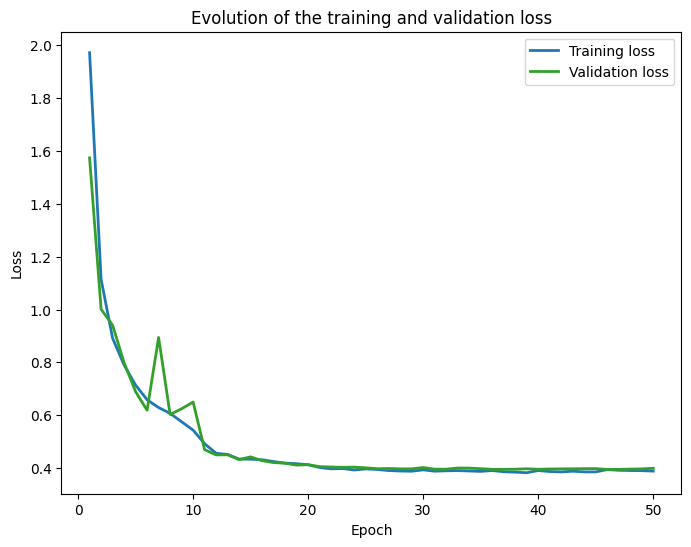

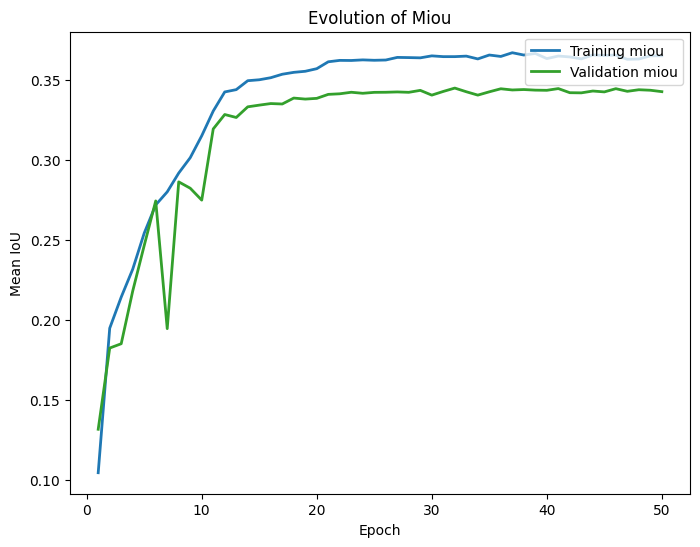

In [ ]:
from torch import optim
from torch.optim import lr_scheduler

from torch_uncertainty.metrics.classification import MeanIntersectionOverUnion

class_names = [muad_class.name for muad_class in train_set.classes]
class_names = class_names[:-3]

print("\nTraining...\n")
num_classes = 19

# Initialize UNet
model = UNet(classes=num_classes).to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Define the metric
metric = MeanIntersectionOverUnion(num_classes=num_classes).to(device)

## Summary of components
# print(f"Model: {model}")
# print(f"Criterion: {criterion}")
# print(f"Optimizer: {optimizer}")
# print(f"Scheduler: {scheduler}")
# print(f"Metric: {metric}")

# We are going to use the CrossEntropyLoss loss function as it's most
# frequentely used in classification problems with multiple classes which
# fits the problem. This criterion  combines LogSoftMax and NLLLoss.

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_miou = []
val_miou = []


print("\nStarting Training...\n")
best_val_loss = float('inf')  # To track the best validation loss

for epoch in tqdm(range(num_epochs), desc="Training Epochs "):
    print(f"Epoch {epoch+1}/{num_epochs}\n")

    # Train the model
    train_loss, train_iou, _ = train(model, train_loader, optimizer, criterion, metric, iteration_loss=True)
    # colored_print(bcolors.WARNING, f"\n\nTrain _iou is {train_iou}\n\n")

    colored_print(bcolors.WARNING, f"")
    train_losses.append(train_loss)
    # train_miou.append(train_iou.mean().item())
    train_miou.append(torch.nanmean(train_iou))


    # Validate the model
    val_loss, val_iou, _ = test(model, val_loader, criterion, metric, iteration_loss=True)
    val_losses.append(val_loss)
    # val_miou.append(val_iou.mean().item())
    val_miou.append(torch.nanmean(val_iou))


    # Step the learning rate scheduler
    scheduler.step()

    # Print losses and metrics
    colored_print(bcolors.OKCYAN, f"Train Loss: {train_loss:.4f}, Train IoU: {torch.nanmean(train_iou).item():.4f}" )
    colored_print(bcolors.OKCYAN, f"Validation Loss: {val_loss:.4f}, Validation IoU: {torch.nanmean(val_iou).item():.4f}")


    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Computer-Vision/model_2.pth')
        colored_print(bcolors.OKGREEN, "Model saved with Validation Loss: {:.4f}".format(val_loss))

# Plot Training and Validation Loss
plot_losses(train_losses, val_losses, i=2)

train_miou_numpy = [tensor.cpu().numpy() for tensor in train_miou]

# Convert val_miou tensors to NumPy arrays
val_miou_numpy = [tensor.cpu().numpy() for tensor in val_miou]

# Plot Training and Validation Mean IoU
plot_accu(train_miou_numpy, val_miou_numpy, i=2)

Load a model

In [23]:
!git clone https://github.com/MarcChen/IA323-ENSTA-Courses.git > /dev/null
!mv /content/IA323-ENSTA-Courses/optional-homework2/model-MUAD.pth . > /dev/null
!mv /content/IA323-ENSTA-Courses/optional-homework2/model_2.pth . > /dev/null
!mv /content/IA323-ENSTA-Courses/optional-homework2/model_3.pth . > /dev/null
!rm -rf IA323-ENSTA-Courses > /dev/null

fatal: destination path 'IA323-ENSTA-Courses' already exists and is not an empty directory.


In [24]:
#Loading a model
model = UNet(19)
model.load_state_dict(torch.load("model-MUAD.pth"))
model = model.to("cuda")

<ipython-input-24-d114eee510c4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model-MUAD.pth"))


# III. Evalution of the Trained DNN on the test

## A. classical evaluations

**Q10/ please plot the loss and miou and comment about it ?**

Both the training and test loss curves show a similar downward trend, stabilizing around 0.3. However, there's a notable difference in the mean Intersection over Union (mIoU) values: the training mIoU reaches approximately 0.40, whereas the test mIoU plateaus at around 0.33. This discrepancy indicates a definite overfitting to the training dataset.

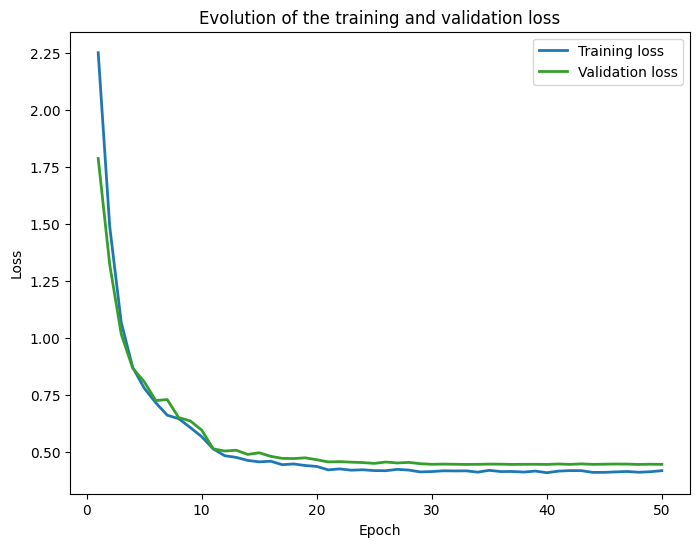

In [ ]:
plot_losses(train_losses, val_losses)

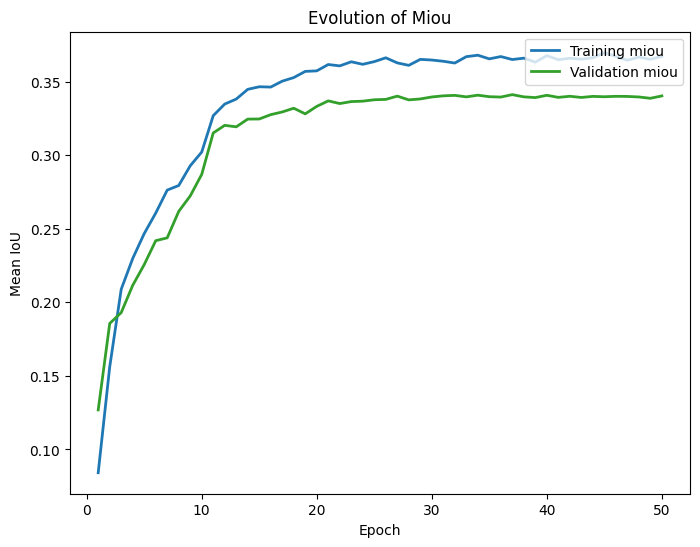

In [ ]:
plot_accu(train_miou_numpy, val_miou_numpy)

**Q11/ what should we have done to avoid overfitting?**



To avoid overfitting, we could:
1. Use data augmentation techniques to increase the diversity of the training data.
2. Implement regularization methods such as weight decay or dropout in the model.
3. Employ early stopping to halt training when validation performance stops improving.
4. Use a smaller, simpler model to reduce the risk of overfitting complex patterns.
5. Increase the amount of training data by collecting or synthesizing more examples.

In [ ]:
# Now we evaluate the model on all the test set.
loss, iou, miou = test(model, test_loader, criterion, metric)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss ," | Mean IoU: ", miou)
# Print per class IoU on last epoch or if best iou
for key, class_iou in zip(class_names, iou, strict=True):
  print(f"{key}: {class_iou:.4f}")

>>>> [FINAL TEST on the test set: ] Avg. loss:  0.4264385973413785  | Mean IoU:  tensor(0.3708, device='cuda:0')
road: 0.9374
sidewalk: 0.6717
building: 0.8265
wall: 0.0000
fence: 0.2997
pole: 0.0000
traffic_light: 0.0000
traffic_sign: 0.0000
vegetation: 0.5848
terrain: 0.0000
sky: 0.9139
person: 0.0000
rider: nan
car: 0.7361
truck: 0.2207
bus: nan
train: nan
motorcycle: nan
bicycle: nan


## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP)


In [ ]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

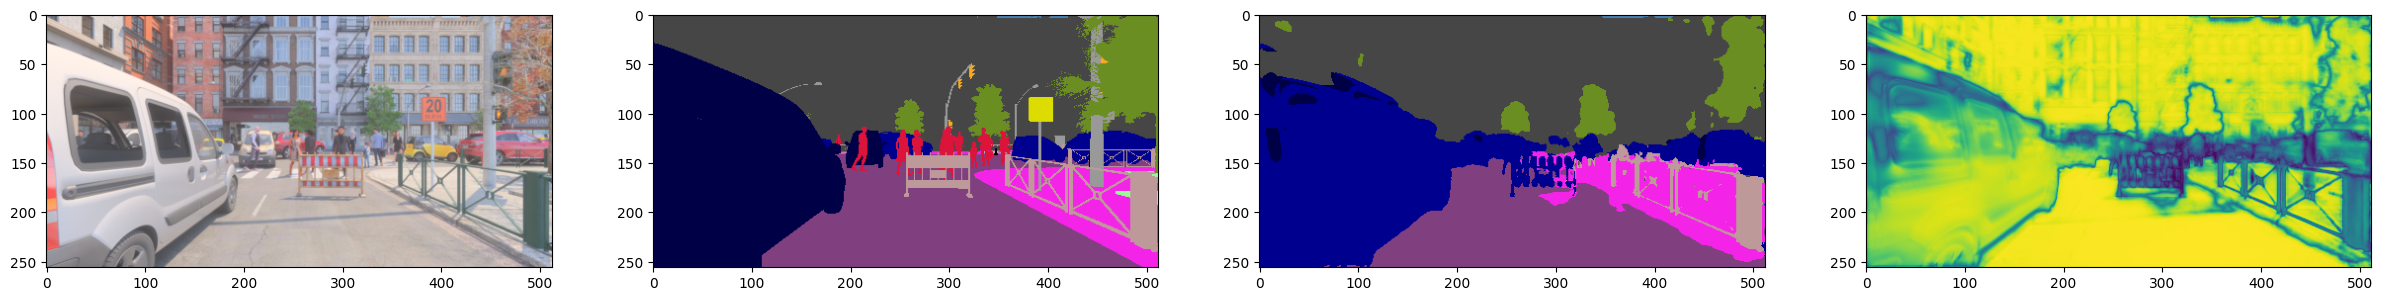

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**


The last image represents the confidence score of the DNN, as it visualizes the maximum probability assigned by the model's softmax output for each pixel. Bright areas indicate high confidence in the predicted class, while dark areas reflect low confidence, often due to ambiguity, occlusion, or lack of distinct features.

>This image helps in visualizing regions where the model performs well versus areas requiring improvement.



### Now let's load the OOD test set

In [ ]:
test_ood_set = MUAD(root="./data", target_type="semantic", version="small", split="ood" , transforms=val_transform, download=True)
test_ood_set
odd_loader = DataLoader(
        test_ood_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2)

ood.zip:   0%|          | 0.00/193M [00:00<?, ?B/s]

In [ ]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

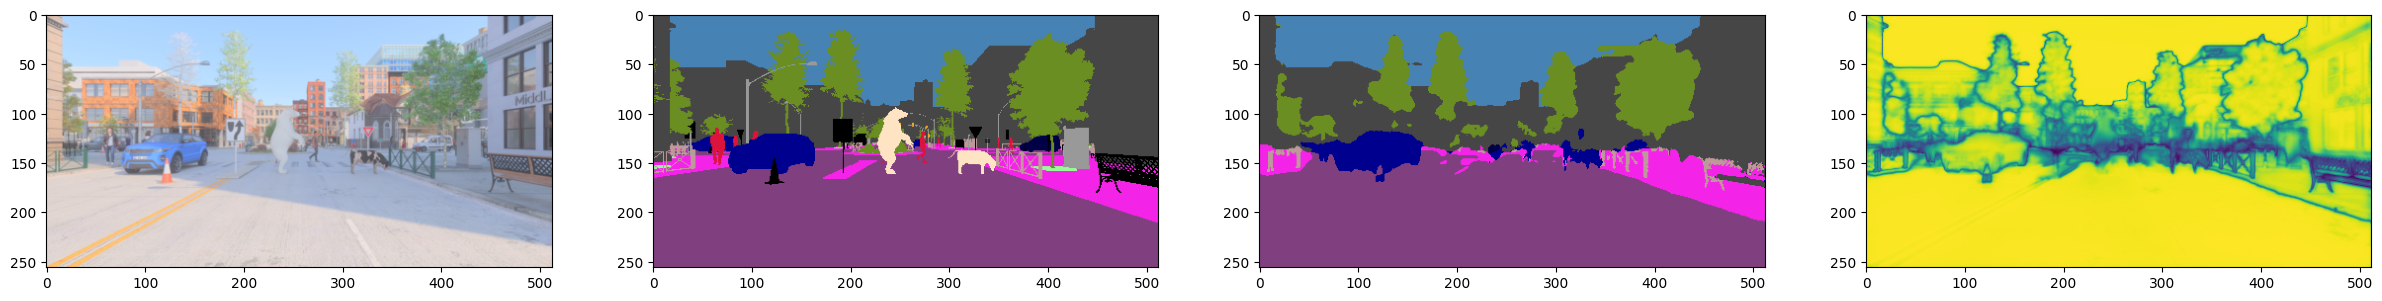

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**According to the output is the model confident when it comes to labeling the bear and goat ? How about the bench ?**


**Q12 bis/ The last image is the related to the confidence score of the DNN. Can you explain why?**
**Are you happy with this image?**


The last image is related to the confidence score of the DNN because it represents the maximum softmax probability for each pixel, highlighting how certain the model is about its predictions. Bright areas show high confidence, while dark areas indicate uncertainty.

> Are we happy with this image?

No, we are not happy with this image. The model demonstrates high confidence in incorrect predictions, as it fails to identify the animals blocking the road. This is critical for applications like autonomous driving, where such misclassification could lead to dangerous decisions, such as assuming the road is clear and driving past objects that actually block the way.

## C. Uncertainty evaluations with Temperature Scaling
**Q13/ please implement a temperature scaling using torch_uncertainty**

Before Temprature scaling

###Link to the tutorial : https://torch-uncertainty.github.io/auto_tutorials/tutorial_scaler.html#sphx-glr-auto-tutorials-tutorial-scaler-py

## RESTART SESSION FROM HERE

ECE before scaling - 2.253%.


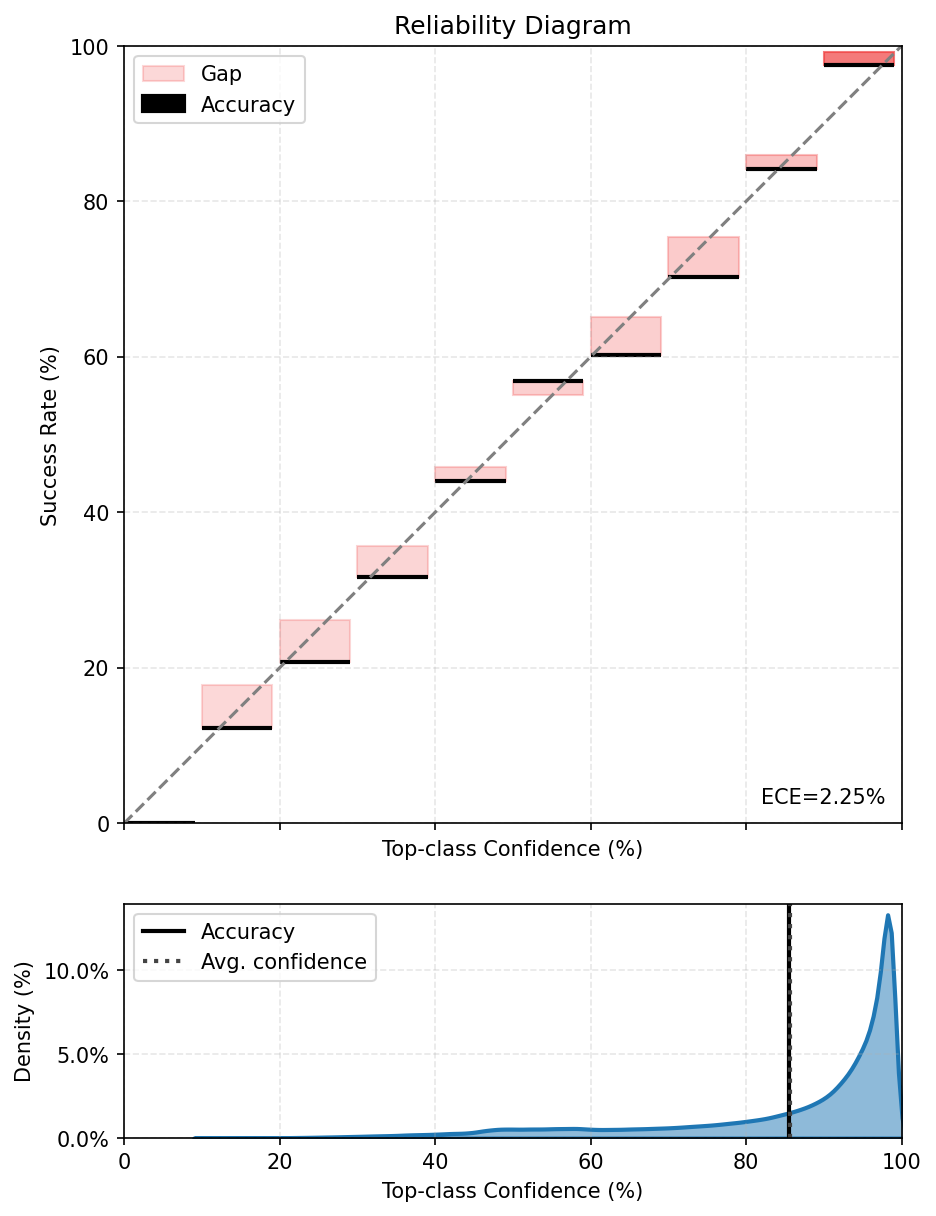

In [ ]:
from torch.utils.data import DataLoader
import torch
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
from torch_uncertainty.metrics import CalibrationError

# Assuming test_loader, model, and other dependencies are properly set up.

# Initialize the ECE
num_classes = 19
ece = CalibrationError(task="multiclass", num_classes=num_classes)

model.eval()

for sample, target in test_loader:
    sample, target = sample.cuda(), target.cuda()
    # Reshape target to remove the extra dimension
    target = target.squeeze(1)  # Shape: [batch_size, height, width]

    with torch.no_grad():
        logits = model(sample)  # Shape: [batch_size, num_classes, height, width]
        probs = logits.softmax(dim=1)  # Apply softmax to the class dimension

        # Flatten the tensors for CalibrationError
        probs = probs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # Shape: [batch_size*height*width, num_classes]
        target = target.reshape(-1)  # Shape: [batch_size*height*width]

        # Update the ECE metric
        ece.update(probs, target)

# Compute and print the final ECE
print(f"ECE before scaling - {ece.compute():.3%}.")

# Plot ECE if applicable
fig, ax = ece.plot()
fig.show()


---

**Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated ?**

After temperature scaling

In [ ]:
from torch.utils.data import Dataset

class SqueezedDataset(Dataset):
    def __init__(self, dataset, device, ignore_value=255):
        """
        Wrap an existing dataset, apply squeezing to the targets, move to the specified device,
        and handle ignored regions in the target.

        Args:
            dataset (Dataset): The original dataset to wrap.
            device (str): The device to move the tensors to ('cpu' or 'cuda').
            ignore_value (int): The value to use for ignored regions in the target.
        """
        self.dataset = dataset
        self.device = device
        self.ignore_value = ignore_value

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        sample = sample.to(self.device)  # Move sample to the specified device
        target = target.squeeze(0).to(self.device)  # Remove the channel dimension and move to device

        # Ensure valid target values
        target[target == self.ignore_value] = -1  # Replace 255 with -1 to represent ignored regions


        return sample, target

In [ ]:
# Wrap the original dataset with SqueezedDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
squeezed_val_set = SqueezedDataset(val_set, device=device)

# # Example DataLoader
# from torch.utils.data import DataLoader
# calibration_loader = DataLoader(squeezed_val_set, batch_size=16, shuffle=False)

In [ ]:
from torch_uncertainty.post_processing import TemperatureScaler

# Fit the scaler on the calibration dataset
scaled_model = TemperatureScaler(model=model)
scaled_model.fit(calibration_set=val_set)
# scaled_model.fit(calibration_set=squeezed_val_set)

In [ ]:
# Reset the ECE
ece.reset()

# Iterate on the test dataloader
for sample, target in val_loader:
    sample, target = sample.cuda(), target.cuda()
    # Reshape target to remove the extra dimension
    target = target.squeeze(1)  # Shape: [batch_size, height, width]

    with torch.no_grad():
        logits = model(sample)  # Shape: [batch_size, num_classes, height, width]
        probs = logits.softmax(dim=1)  # Apply softmax to the class dimension

        # Flatten the tensors for CalibrationError
        probs = probs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # Shape: [batch_size*height*width, num_classes]
        target = target.reshape(-1)  # Shape: [batch_size*height*width]

        # Update the ECE metric
        ece.update(probs, target)

print(f"ECE after scaling - {ece.compute():.3%}.")


Now let's see the new confidence score image after scaling

In [ ]:
fig, ax = ece.plot()
fig.show()

**Did the model get more confident ? or is it more calibrated ? Commnet on the temperature scaling graphs and results**

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q\14 Please implement MC Dropout using torch_uncertainty**

In [ ]:
import torch
import numpy as np

def mc_dropout(model, inputs, num_samples=10):
    """
    Perform Monte Carlo Dropout to estimate uncertainty.

    Args:
        model (nn.Module): The trained model with dropout layers.
        inputs (torch.Tensor): The input tensor.
        num_samples (int): The number of forward passes to perform.

    Returns:
        mean_prediction (torch.Tensor): Mean of predictions across forward passes.
        uncertainty (torch.Tensor): Variance of predictions across forward passes.
    """
    model.train()  # Keep dropout active during inference
    predictions = []

    for _ in range(num_samples):
        with torch.no_grad():
            predictions.append(model(inputs).cpu())

    predictions = torch.stack(predictions)  # Shape: [num_samples, batch_size, C, H, W]
    mean_prediction = predictions.mean(dim=0)
    uncertainty = predictions.var(dim=0)
    return mean_prediction, uncertainty


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs, labels = next(iter(test_loader))  # Get a batch of test data
inputs = inputs.to(device)


Number of Samples: 3
Mean Prediction Shape: torch.Size([5, 19, 256, 512])
Uncertainty Shape: torch.Size([5, 19, 256, 512])


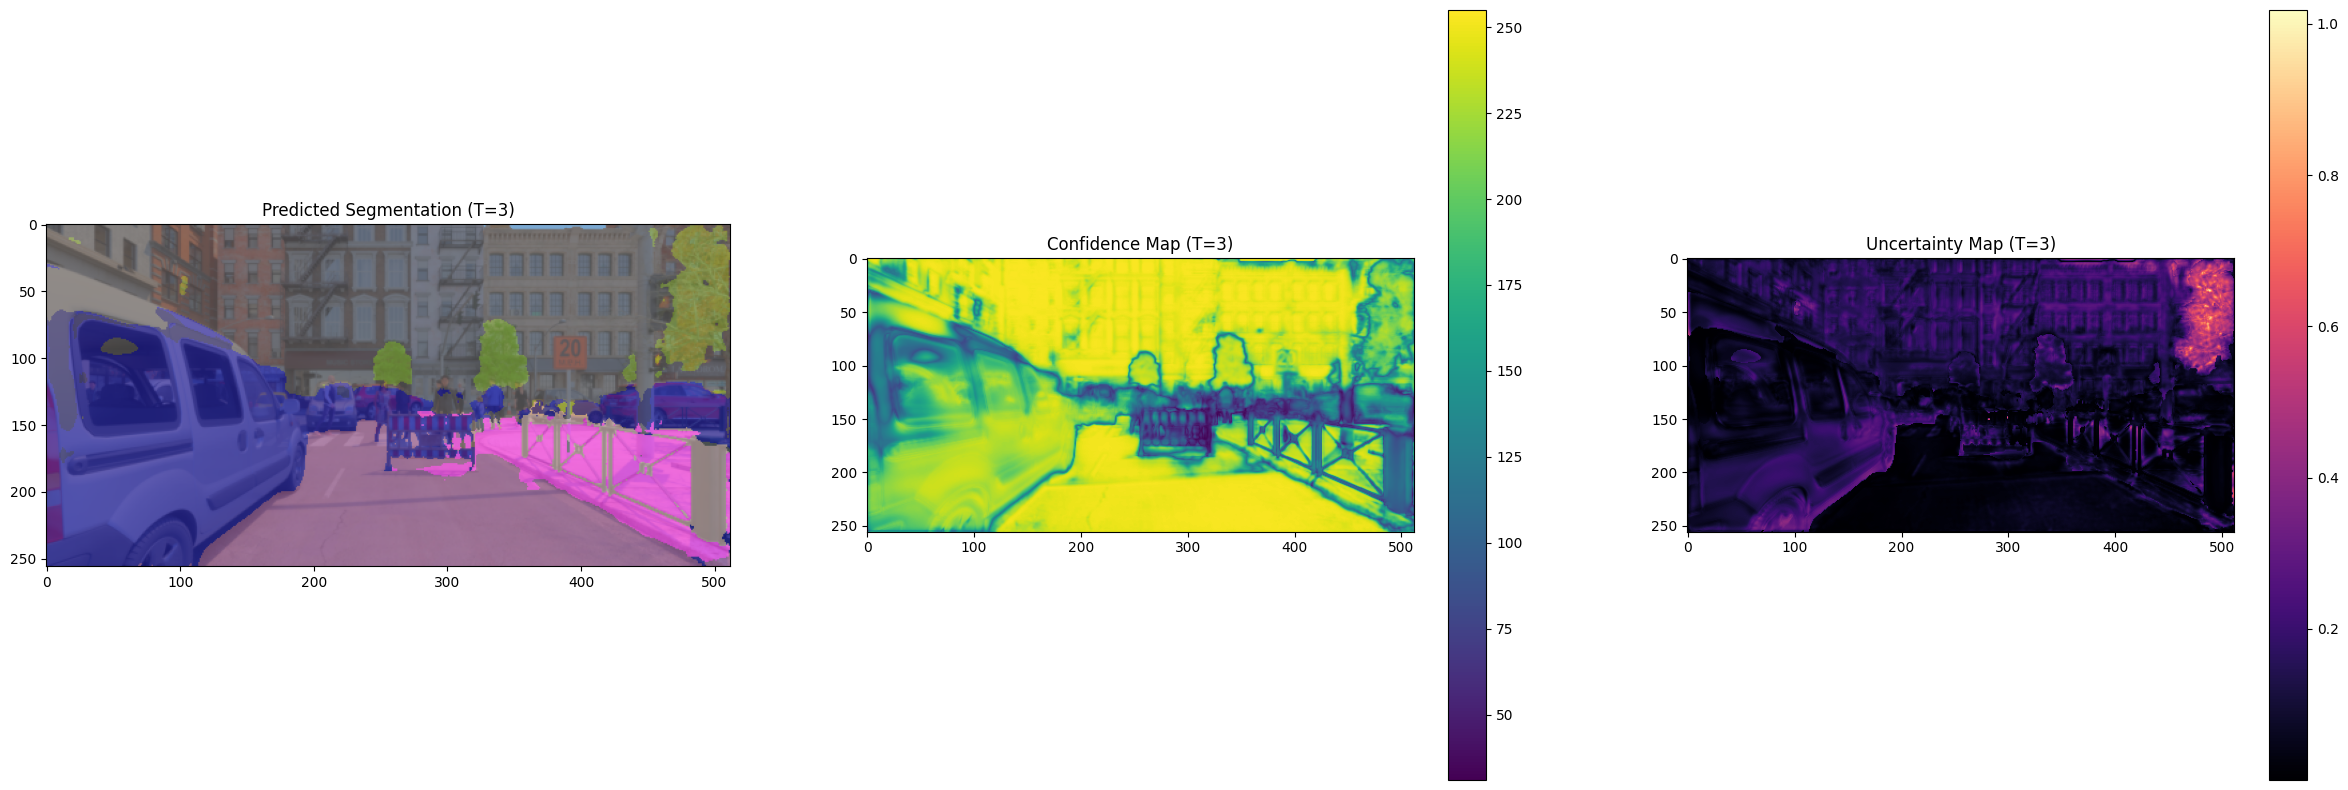


Number of Samples: 20
Mean Prediction Shape: torch.Size([5, 19, 256, 512])
Uncertainty Shape: torch.Size([5, 19, 256, 512])


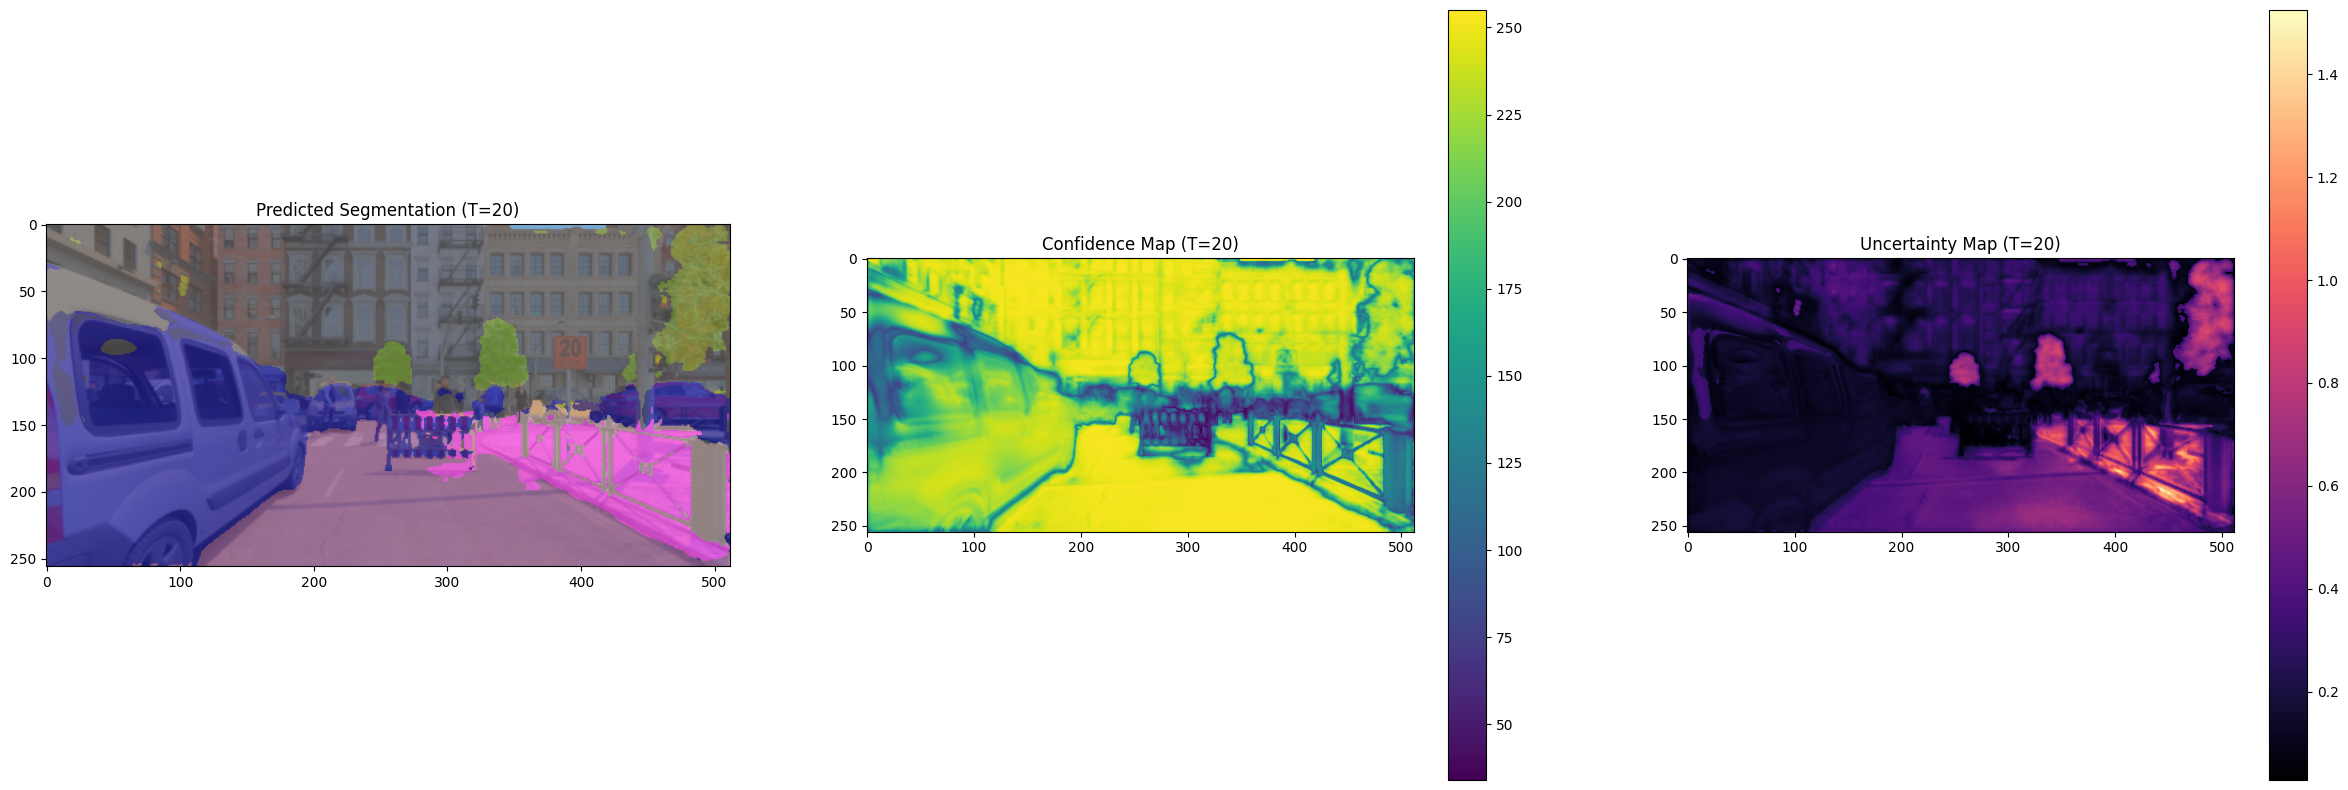

In [ ]:
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# MC Dropout with different estimators
for num_samples in [3, 20]:
    mean_prediction, uncertainty = mc_dropout(model.to(device), inputs, num_samples=num_samples)

    print(f"\nNumber of Samples: {num_samples}")
    print(f"Mean Prediction Shape: {mean_prediction.shape}")
    print(f"Uncertainty Shape: {uncertainty.shape}")

    # Extract confidence map and prediction
    outputs_proba = mean_prediction.softmax(dim=1)  # Convert logits to probabilities
    confidence, pred = outputs_proba.max(dim=1)  # Confidence and predicted class

    # Undo normalization on the input image
    mean = torch.tensor([0.485, 0.456, 0.406], device=inputs.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=inputs.device)
    img = inputs[0] * std[:, None, None] + mean[:, None, None]

    # Create segmentation masks for prediction
    pred_masks = pred[0] == torch.arange(outputs_proba.shape[1], device=pred.device)[:, None, None]

    # Draw segmentation mask for prediction
    pred_img = draw_segmentation_masks(
        (img * 255).byte(),
        masks=pred_masks,
        alpha=0.6,
        colors=test_set.color_palette
    )

    # Normalize confidence to 0–1 and convert to PIL
    confidence_img = to_pil_image(confidence[0] / confidence[0].max())

    # Extract uncertainty for the predicted class, remaining on GPU
    uncertainty_img = uncertainty[0].gather(0, pred[0][None, :, :]).squeeze(0)  # Use `gather` to index on GPU
    uncertainty_img = uncertainty_img.detach().cpu().numpy()  # Move the final result to CPU

    # Visualize the results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

    # Original Image with Prediction
    ax1.imshow(to_pil_image(pred_img))
    ax1.set_title(f"Predicted Segmentation (T={num_samples})")

    # Confidence Map
    confidence_display = ax2.imshow(confidence_img, cmap="viridis")
    ax2.set_title(f"Confidence Map (T={num_samples})")
    plt.colorbar(confidence_display, ax=ax2)

    # Uncertainty Map
    ax3.imshow(uncertainty_img, cmap="magma")
    ax3.set_title(f"Uncertainty Map (T={num_samples})")
    plt.colorbar(ax3.imshow(uncertainty_img, cmap="magma"), ax=ax3)

    plt.show()


**Try the MC dropout code with a low number of estimators T like 3 and a high number 20, Explain the diffrence seen on the confidence image, is the model getting more confident or less ?**

With
𝑇
=
3
, the confidence map remains stable and shows the model's high confidence in its predictions, as the most probable class dominates even with fewer forward passes. However, the uncertainty map is noisier and less reliable due to the limited number of samples used to estimate variance. When
𝑇
=
20
, the confidence map becomes slightly smoother but does not change significantly, **reflecting the model's consistent confidence**. In contrast, the uncertainty map improves considerably, becoming more stable and accurately highlighting ambiguous regions, such as object boundaries or overlapping features.

## E. Uncertainty evaluations with Deep Ensembles
**Q\15 Please implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

In [ ]:
from torch_uncertainty.models import deep_ensembles

In [25]:
all_models = []

model = UNet(19)
model.load_state_dict(torch.load("model-MUAD.pth"))
all_models.append(model)

model = UNet(19)
model.load_state_dict(torch.load("model_2.pth"))
all_models.append(model)

model = UNet(19)
model.load_state_dict(torch.load("model_3.pth"))
all_models.append(model)


<ipython-input-25-8d0ccd80b5dd>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model-MUAD.pth"))
<ipython-input-25-8d0ccd80b5dd>:8: Futur

In [ ]:
from torch_uncertainty.models import deep_ensembles
from torch_uncertainty.transforms import RepeatTarget
from torch_uncertainty.routines import ClassificationRoutine
from torch_uncertainty import TUTrainer


ensemble = deep_ensembles(
    all_models,
    num_estimators=None,
    task="classification",
    reset_model_parameters=True,
)

ens_routine = ClassificationRoutine(
    is_ensemble=True,
    num_classes=19,
    model=ensemble,
    loss=nn.CrossEntropyLoss(),  # The loss for the training
    format_batch_fn=RepeatTarget(
        3
    ),  # How to handle the targets when comparing the predictions
    optim_recipe=None,  # No optim recipe as the model is already trained
    eval_ood=True,  # We want to evaluate the OOD-related metrics
)

trainer = TUTrainer(accelerator="gpu", max_epochs=1)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `FPR95` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Test your ensemble obtained either using option 1 or 2.

In [ ]:
results = trainer.test(ens_routine, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

EinopsError:  Error while processing rearrange-reduction pattern "(n b) c -> b n c".
 Input tensor shape: torch.Size([15, 19, 256, 512]). Additional info: {'b': 5}.
 Wrong shape: expected 2 dims. Received 4-dim tensor.

Save the ensemble model

In [ ]:
final_model_path = "/content/drive/MyDrive/Computer-Vision/ensemble.pth"
torch.save(ensemble.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

## F. Uncertainty evaluations with Packed-Ensembles
**Q\15 Please read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty**


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.mpconv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.interpolate(x1, size=[2 * x1.size()[2], 2 * x1.size()[3]],
                               mode='bilinear', align_corners=True)
        else:
            x1 = self.up(x1)

        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

class PackedEnsembleUNet(nn.Module):
    def __init__(self, classes, ensemble_size=5):
        super().__init__()
        self.ensemble_size = ensemble_size
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)

        # Ensemble heads
        self.ensemble_heads = nn.ModuleList([
            OutConv(32, classes) for _ in range(ensemble_size)
        ])

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)

        # Ensemble outputs
        outputs = torch.stack([head(x) for head in self.ensemble_heads], dim=1)
        return outputs

    def compute_uncertainty(self, outputs):
        """
        Computes uncertainty as the variance across ensemble outputs.
        """
        return outputs.var(dim=1)

# Example usage:
# model = PackedEnsembleUNet(classes=19, ensemble_size=5)
# x = torch.randn(1, 3, 256, 256)  # Example input
# outputs = model(x)
# uncertainty = model.compute_uncertainty(outputs)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Assuming PackedEnsembleUNet is already defined

def train_model(model, dataloader, epochs=5, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)

            # Ensemble outputs (average predictions)
            outputs_mean = outputs.mean(dim=1)

            # Loss calculation
            loss = criterion(outputs_mean, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(dataloader):.4f}")

    return model

# Uncertainty evaluation
@torch.no_grad()
def evaluate_uncertainty(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute uncertainty
        uncertainty = model.compute_uncertainty(outputs)

        # Visualize one example
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(images[0].cpu().permute(1, 2, 0))
        ax[0].set_title("Input Image")

        ax[1].imshow(labels[0].cpu(), cmap="viridis")
        ax[1].set_title("Ground Truth")

        ax[2].imshow(uncertainty[0].cpu().numpy(), cmap="hot")
        ax[2].set_title("Uncertainty Map")

        plt.show()
        break

# Instantiate model
model = PackedEnsembleUNet(classes=19, ensemble_size=5)

# Train the model
trained_model = train_model(model, train_loader, epochs=5)

# Evaluate uncertainty
evaluate_uncertainty(trained_model, train_loader)


**Please conclude your report**

---